# Polluted Fossils of Reionization -- What Causes Them To Quench? 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle
import pynbody
pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue, pynbody.halo.hop.HOPCatalogue]

%matplotlib inline
print(mpl.get_backend())
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

module://ipykernel.pylab.backend_inline


In [2]:
def read_file(name, halo_num):
    data = []
    with open('/home/akinshol/Data/Timescales/DataFiles/'+name+'.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    data = pd.DataFrame(data)
    
    if not halo_num=='all':
        data = data[data.z0haloid == halo_num]

    return data

def cumulative_sfh(name, halo_num):
    age = 13.800797497330507
    if name=='h148':
        s = pynbody.load('/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.004096')
    else:
        s = pynbody.load('/home/christenc/Data/Sims/'+name+'.cosmo50PLK.3072g/'+name+'.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/'+name+'.cosmo50PLK.3072gst5HbwK1BH.004096')
    halo = s.halos()[halo_num]
    try:
        sfh, bins = pynbody.plot.stars.sfh(halo, filename=None, massform=False, clear=False, legend=False, subplot=False, trange=False, bins=128)
        plt.clf()
    except ValueError:
        print(f'Cannot create SFH, only {len(halo.s)} star particles')
        raise

    sfhmstar = np.sum(sfh)
    bincenters = 0.5*(bins[1:]+bins[:-1])
    c_sfh = np.empty(shape=sfh.shape)
    for i in range(len(bincenters)):
        c_sfh[i] = np.sum(sfh[:i+1])/sfhmstar 
    return c_sfh, age-bincenters


In [62]:
def CaseStudyPlots(simulation_name,i,filename=True):

    data = read_file(simulation_name, i)
    # data[:10]

    age = 13.800797497330507
    q_thresh = 0.9
    i_thresh = 1.0
    
    print('Gathering data...')
    time = age - np.array(data['time'], dtype=float)
    gasfrac = np.array(data['gasfrac'], dtype=float)
    gastemp = np.array(data['gtemp'], dtype=float)
    ratio = np.array(data['ratio'], dtype=float)
    dist = np.array(data['h1dist'], dtype=float)
    SNHf = np.array(data['SNHfrac'], dtype=float)
    fHI = np.array(data['fHI'], dtype=float)
    mvir = np.array(data['mass'], dtype=float)
    HIratio = np.array(data['HIratio'], dtype=float)
    mHI = np.array(data['HIratio'],dtype=float)*np.array(data['mstar'],dtype=float)
    mgas = np.array(data['mgas'],dtype=float)
    c_sfh, bc = cumulative_sfh(simulation_name, i)

    shaded_min = -1
    shaded_max = 500*np.max(mgas)

    fig, ax = plt.subplots(1,4,figsize=(24,4),dpi=300)
    
    ax[3].plot(time,dist,'g-')
    ax[3].invert_xaxis()
    ax[3].set_xlabel('Lookback Time [Gyr]')
    label3 = ax[3].set_ylabel(r'Distance from Host [$R_{\mathrm{vir}}$]')
    label3.set_color('g')
    ax[3].semilogy()
    ax[3].set_xlim(14,0)
    ax[3].set_ylim(0.1, 25)

    ax1 = ax[3].twinx()
    ax1.plot(time,ratio,'m-')
    label4 = ax1.set_ylabel(r'$P_{\mathrm{ram}} / P_{\mathrm{rest}}$')
    label4.set_color('m')
    try:
        ax1.set_ylim(np.min(ratio[~np.isnan(ratio)])-0.3, np.max(ratio[~np.isnan(ratio)])+1)
    except:
        ax1.set_ylim(0., 10)
    npeaks = 1
    peak_indices = np.argsort(ratio[~np.isnan(ratio)])[-npeaks:]


    ax[3].fill_between(time, shaded_min, shaded_max, where=(dist < 1), edgecolor='none',alpha=0.2, facecolor='g')

    for index in peak_indices:
        t = time[~np.isnan(ratio)][index]
        ax[3].plot([t,t],[shaded_min,shaded_max], 'm--', linewidth=1)

    
    for i in [0,1,2]:
        ax[i].fill_between(time, shaded_min, shaded_max, where=(dist < 1), edgecolor='none',alpha=0.2, facecolor='g')

    for i in [0,1,2]:
        for index in peak_indices:
            t = time[~np.isnan(ratio)][index]
            ax[i].plot([t,t],[shaded_min,shaded_max], 'm--', linewidth=1)


    ax[0].plot(bc, c_sfh, 'r-')
    ax[0].invert_xaxis()
    ax[0].set_xlabel('Lookback Time [Gyr]')
    label1 = ax[0].set_ylabel('Cumulative, Normalized SFH')
    label1.set_color('r')
    ax[0].set_ylim(-0.05,1.05)
    ax[0].set_xlim(14,0)

    ax0 = ax[0].twinx()
    ax0.plot(time,HIratio,'b-')
    ax0.set_ylim(-1,10)
    label2 = ax0.set_ylabel(r'$M_{\mathrm{HI}}\ /\ M_{*}$')
    label2.set_color('b')
    t = np.max(bc[c_sfh >= 0.99])

    for i in [0,1,2]:
        ax[i].plot([t,t],[shaded_min,shaded_max], 'r--', linewidth=1)


    ax[1].plot(time,mHI,color='#370ec2',label='HI', linestyle='-')
    ax[1].plot(time,mgas,color='#370ec2',label='All Gas', linestyle='--')
    ax[1].set_xlabel('Lookback Time [Gyr]')
    label = ax[1].set_ylabel(r'Gas Mass [$M_{\odot}$]')
    label.set_color('#370ec2')
    ax[1].legend(frameon=False)
    ax[1].semilogy()
    ax[1].invert_xaxis()
    ax[1].set_xlim(14,0)
    allgas = np.append(mgas,mHI)
    allgas = allgas[(~np.isnan(allgas)) & (allgas!=0)]
    ax[1].set_ylim(0.5*np.min(allgas),1.4*np.max(allgas))

    ax1 = ax[1].twinx()
    ax1.plot(time,gastemp,'k-')
    ax1.invert_xaxis()
    ax1.set_xlabel('Lookback Time [Gyr]')
    ax1.set_ylabel('Mean Gas Temperature [K]')
    ax1.set_xlim(14,0)
    ax1.set_ylim(0.85*np.min(gastemp[~np.isnan(gastemp)]), 1.05*np.max(gastemp[~np.isnan(gastemp)]))

    # ax[2].set_ylim(0.85*np.min(gastemp[~np.isnan(gastemp)]), 1.4*np.max(gastemp[~np.isnan(gastemp)]))
    # ax[2].plot(time,data['outflow_temp_23'],label='Outflow')
    # ax[2].plot(time,data['inflow_temp_23'],label='Inflow')
    # ax[2].legend(frameon=False, prop={'size':9})
    # ax[2].semilogy()


    netflux = data['outflow_91'] + data['inflow_91']
    # ax[2].plot(time, netflux, color='#ad7617', linestyle='-')
    # ax[2].invert_xaxis()
    # label5 = ax[2].set_ylabel(r'Net Gas Flux [$M_{\mathrm{\odot}}\ \mathrm{yr}^{-1}$]')
    # label5.set_color('#ad7617')
    # ax[2].set_ylim(1.2*np.min(netflux),1.2*np.max(netflux))
    for i in [0,1,2]:
        ax[i].fill_between(time, shaded_min,shaded_max, where=(netflux < 0.), edgecolor='none',alpha=0.2, facecolor='#ad7617')

    ax[2].invert_xaxis()
    ax[2].plot(time,abs(data['outflow_91']), color='r',label='outflow')
    ax[2].plot(time,abs(data['inflow_91']), color='orange', label='inflow')
    ax[2].set_ylabel('Outflow Rate / Inflow Rate')
    ax[2].legend(frameon=False)
    alloutflows = np.append(abs(data['outflow_91']),abs(data['inflow_91']))
    alloutflows = alloutflows[~np.isnan(alloutflows)]

    if (alloutflows == 0.).all():
        ax[2].set_ylim(-0.001,0.001)
    else:
        ax[2].set_ylim(-0.001,1.3*np.max(alloutflows))
    ax[2].set_xlim(14,0)

    ax2 = ax[2].twinx()
    gas_rho = np.array(data.gas_rho)
    gas_temp = np.array(data.gas_temp)
    gas_mass =np.array(data.gas_mass)
    
    frac_SF = np.array([],dtype=float)
    for i in range(len(data)):
        gm = np.array(gas_mass[i])
        gr = np.array(gas_rho[i])
        #gt = np.array(gas_temp[i])
        if len(gm[gr> 1e7])>0:
            m = np.sum(gm[gr > 1e7]) / np.sum(gm)
        else:
            m = 0
        frac_SF = np.append(frac_SF, m)
    
    ax2.plot(time, frac_SF , c='b')
    ax2.set_ylim(-0.05,1.05)
    label = ax2.set_ylabel('Dense Gas Fraction')
    label.set_color('b')



    plt.subplots_adjust(wspace=0.45)
    if filename:
        f = 'case_study_'+str(simulation_name)+'_'+str(i)+'.png'
        plt.savefig('CaseStudyPlots/'+f, dpi=300)
    else:
        plt.savefig('CaseStudyPlots/'+str(filename), dpi=300)
    plt.show()

In [63]:
ids = [96, 128, 212, 265, 386, 699, 30, 40, 71, 78, 86, 223, 480, 53, 113, 212, 40, 133, 137,33]
sims = ['h148', 'h148', 'h148', 'h148', 'h148', 'h148', 'h242', 'h242', 'h242', 'h242', 'h242', 'h242', 'h242', 'h229', 'h229', 'h229', 'h329', 'h329', 'h329','h229']

h148-96
Gathering data...


<Figure size 432x288 with 0 Axes>

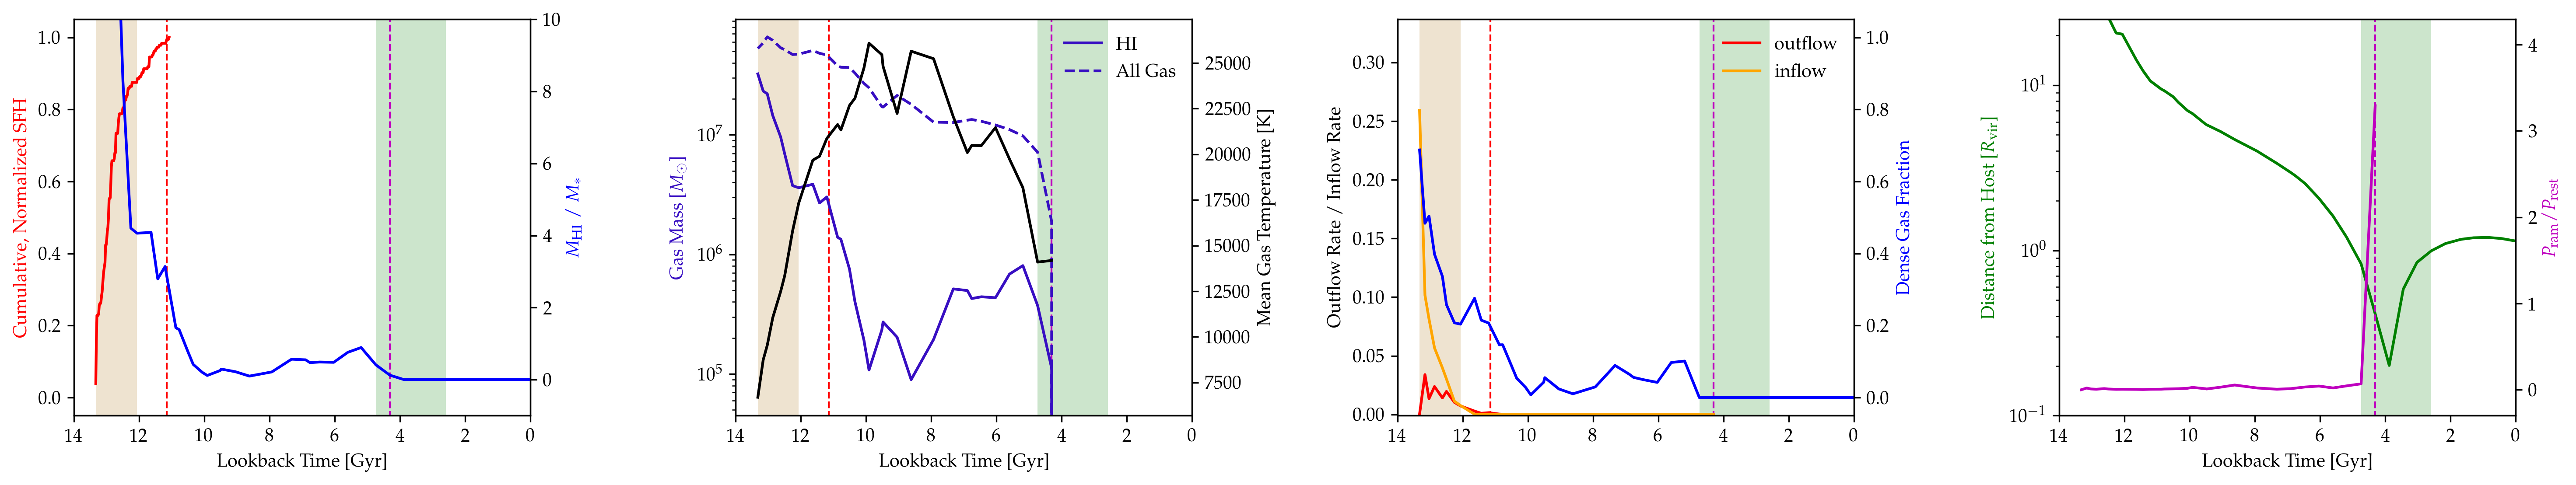

h148-128
Gathering data...


<Figure size 432x288 with 0 Axes>

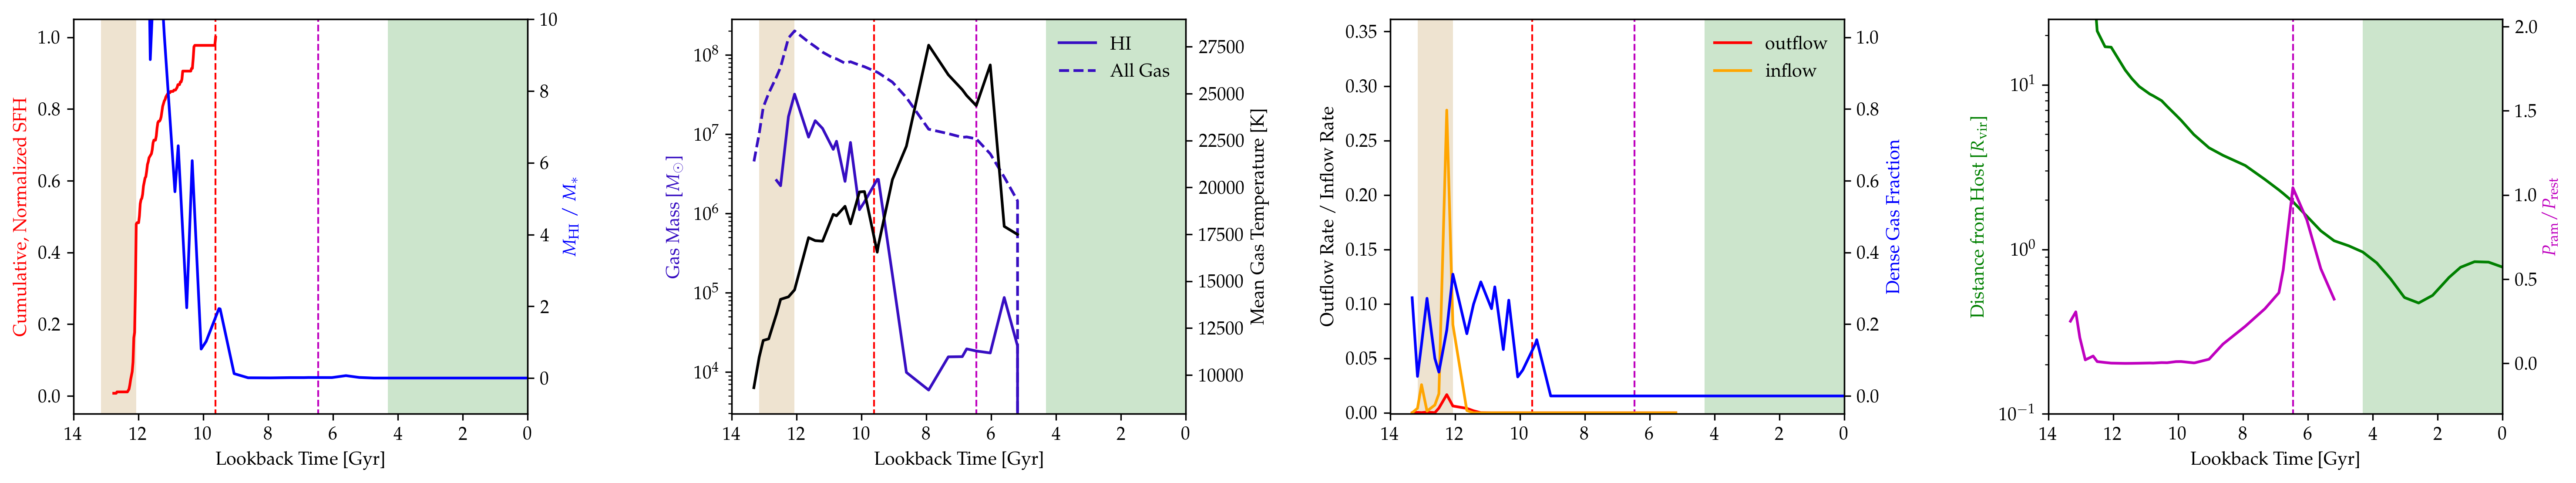

h148-212
Gathering data...


<Figure size 432x288 with 0 Axes>

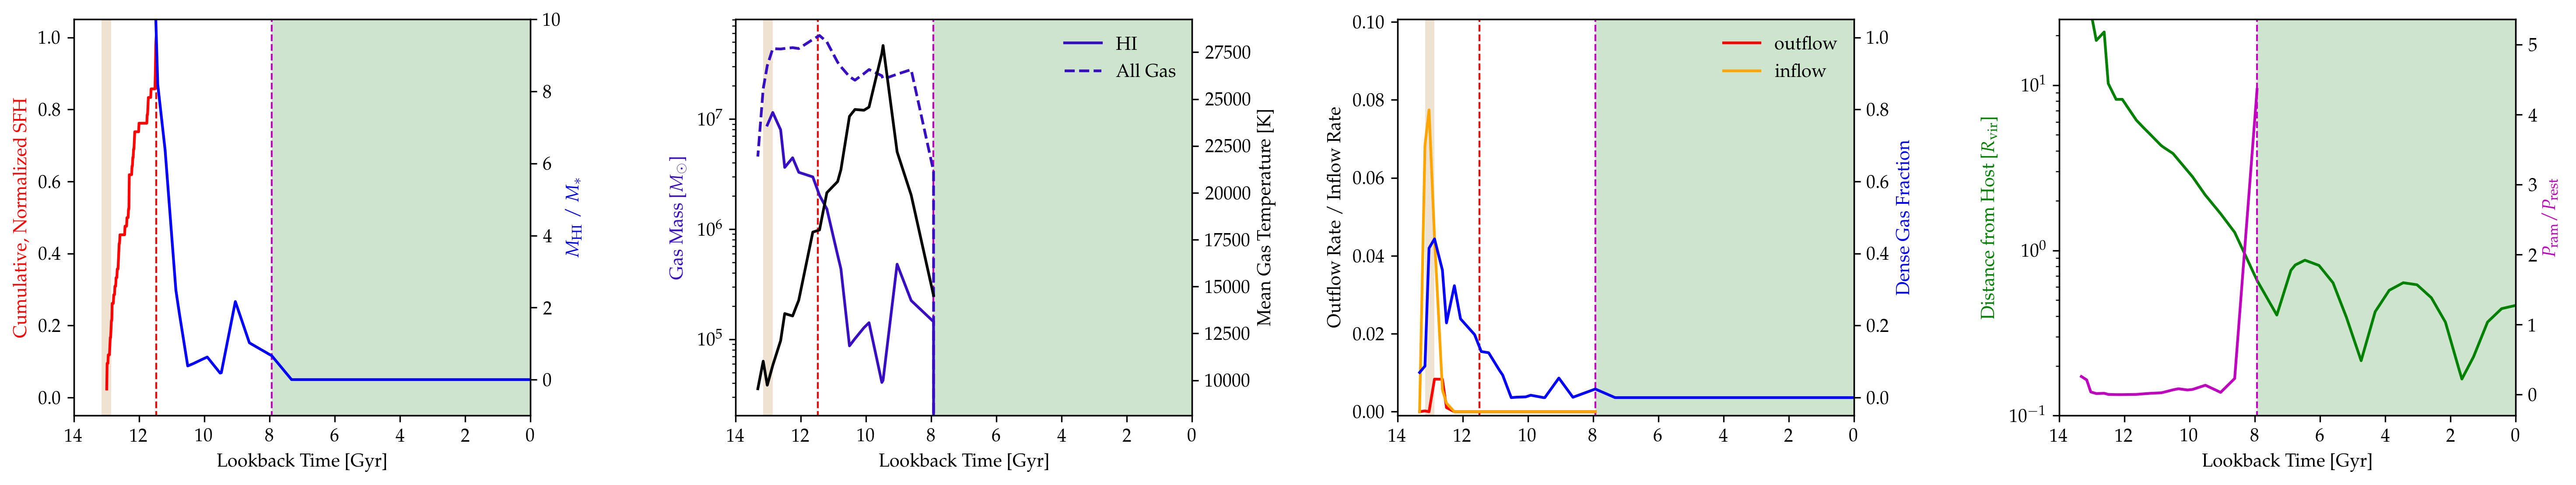

h148-265
Gathering data...


<Figure size 432x288 with 0 Axes>

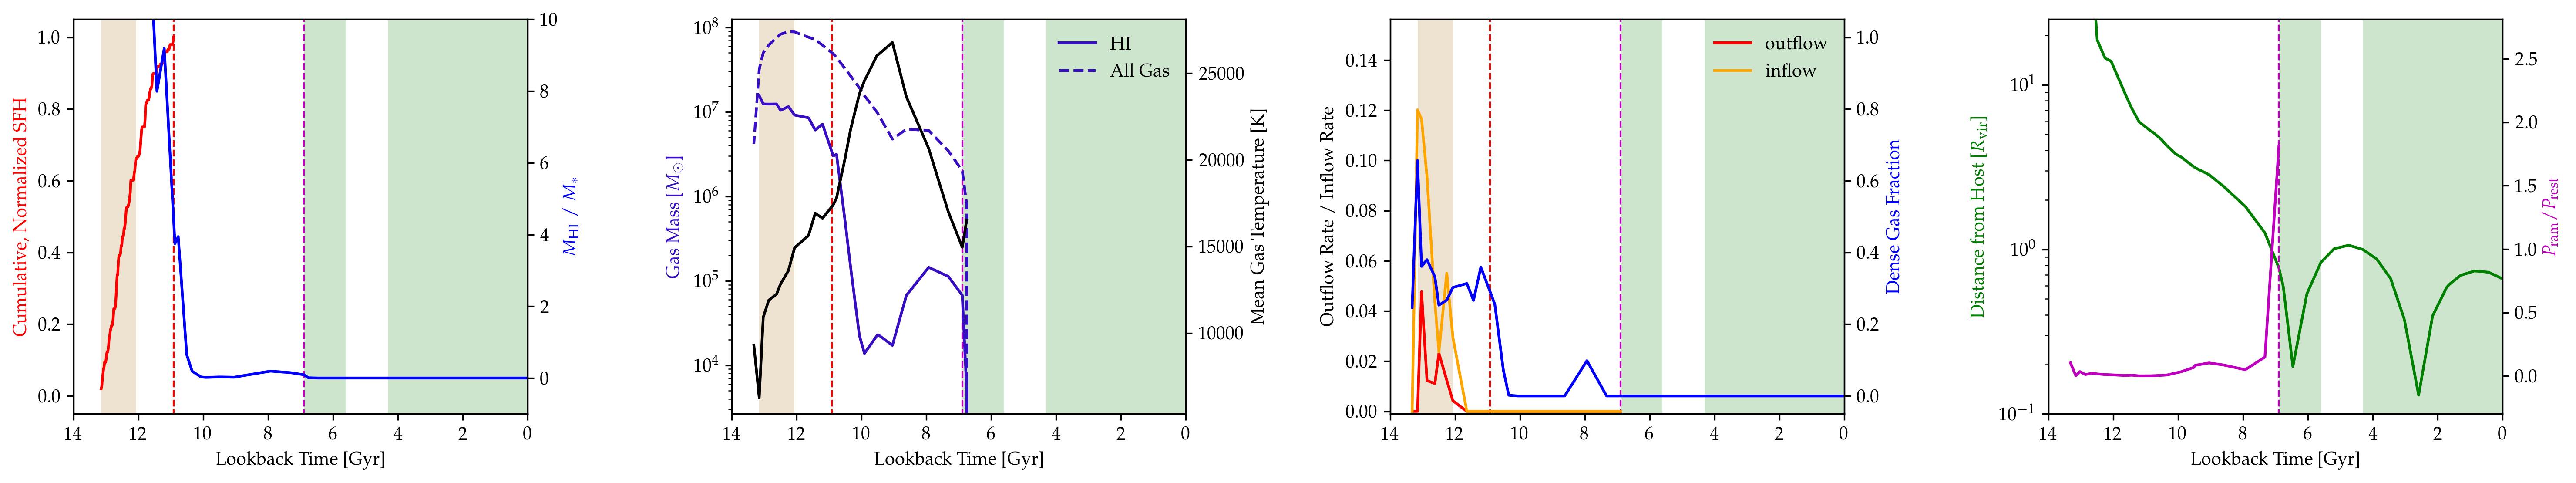

h148-386
Gathering data...


<Figure size 432x288 with 0 Axes>

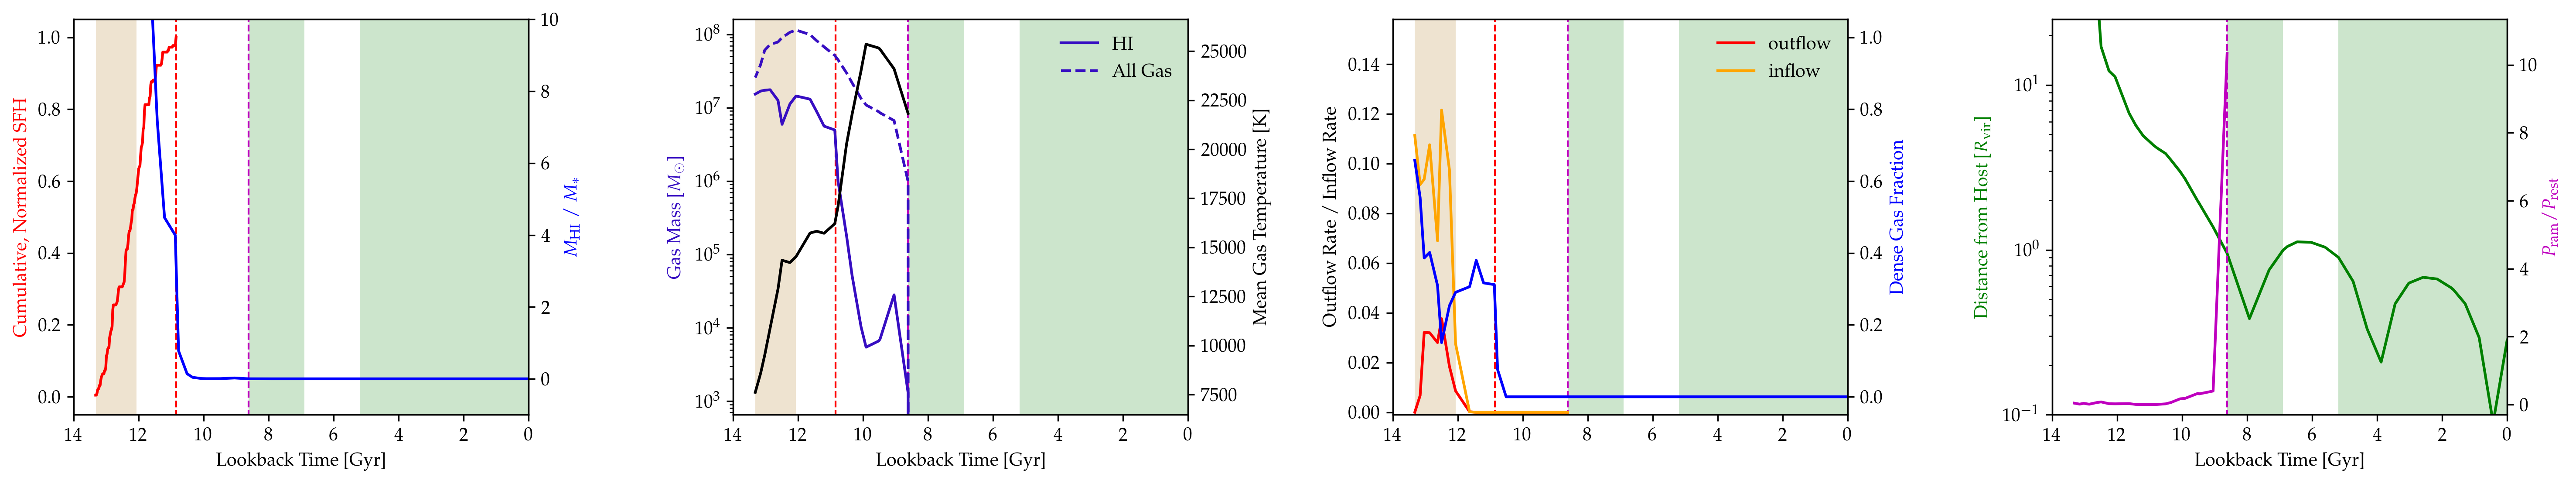

h148-699
Gathering data...


<Figure size 432x288 with 0 Axes>

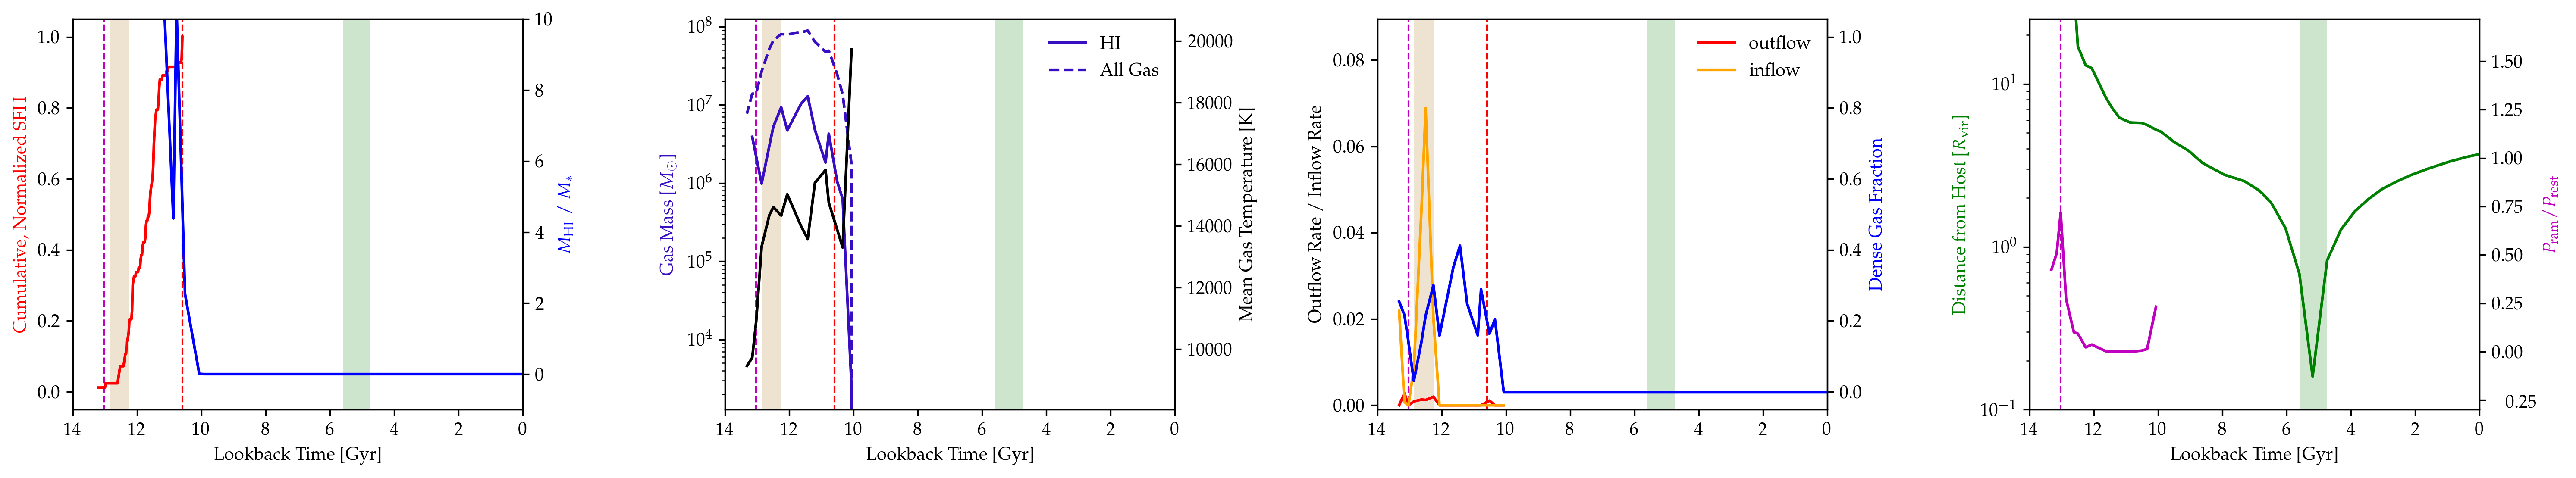

h242-30
Gathering data...


<Figure size 432x288 with 0 Axes>

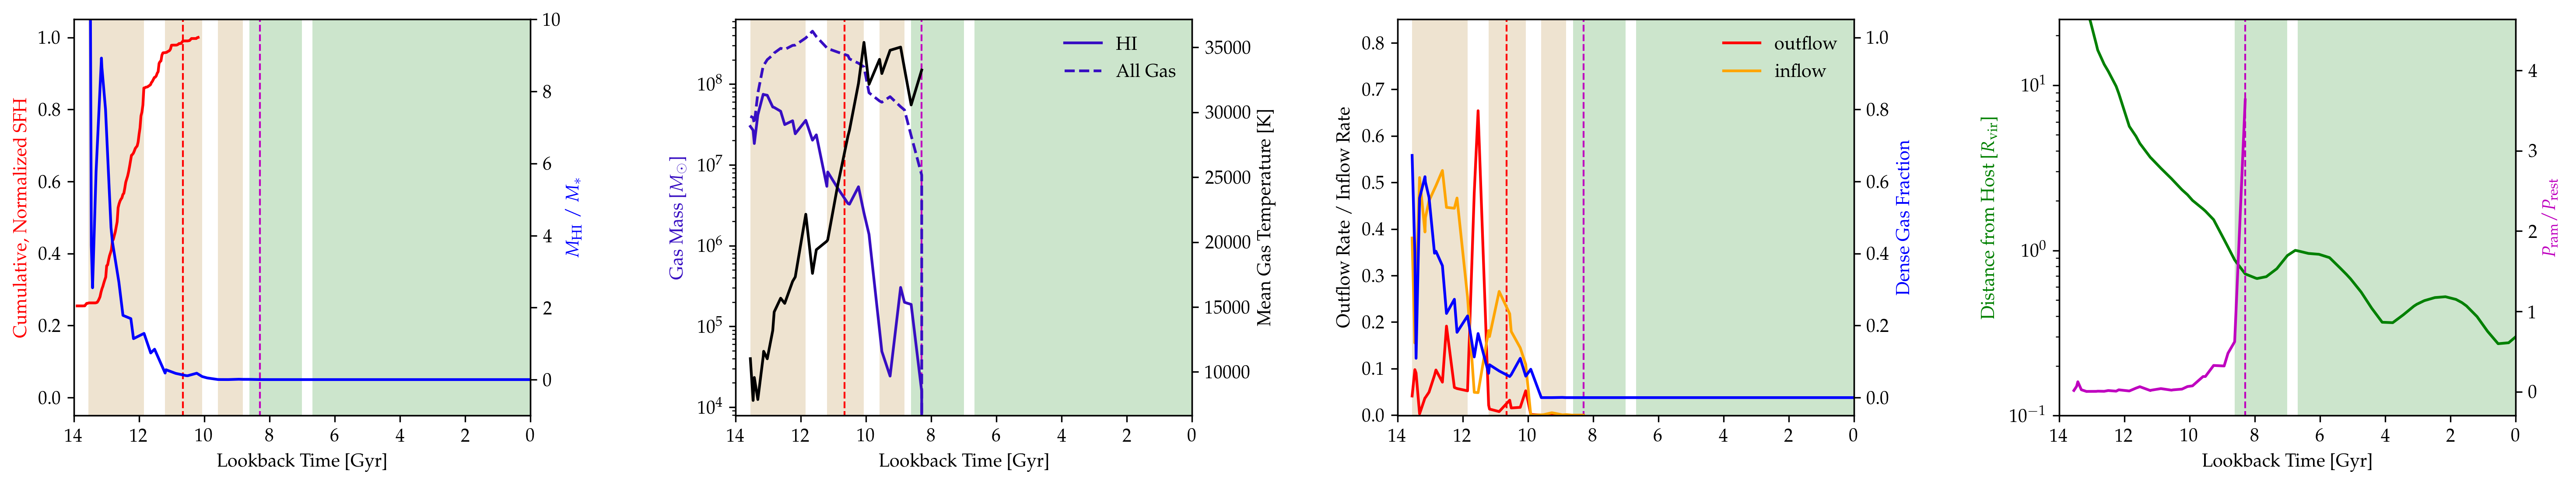

h242-40
Gathering data...


<Figure size 432x288 with 0 Axes>

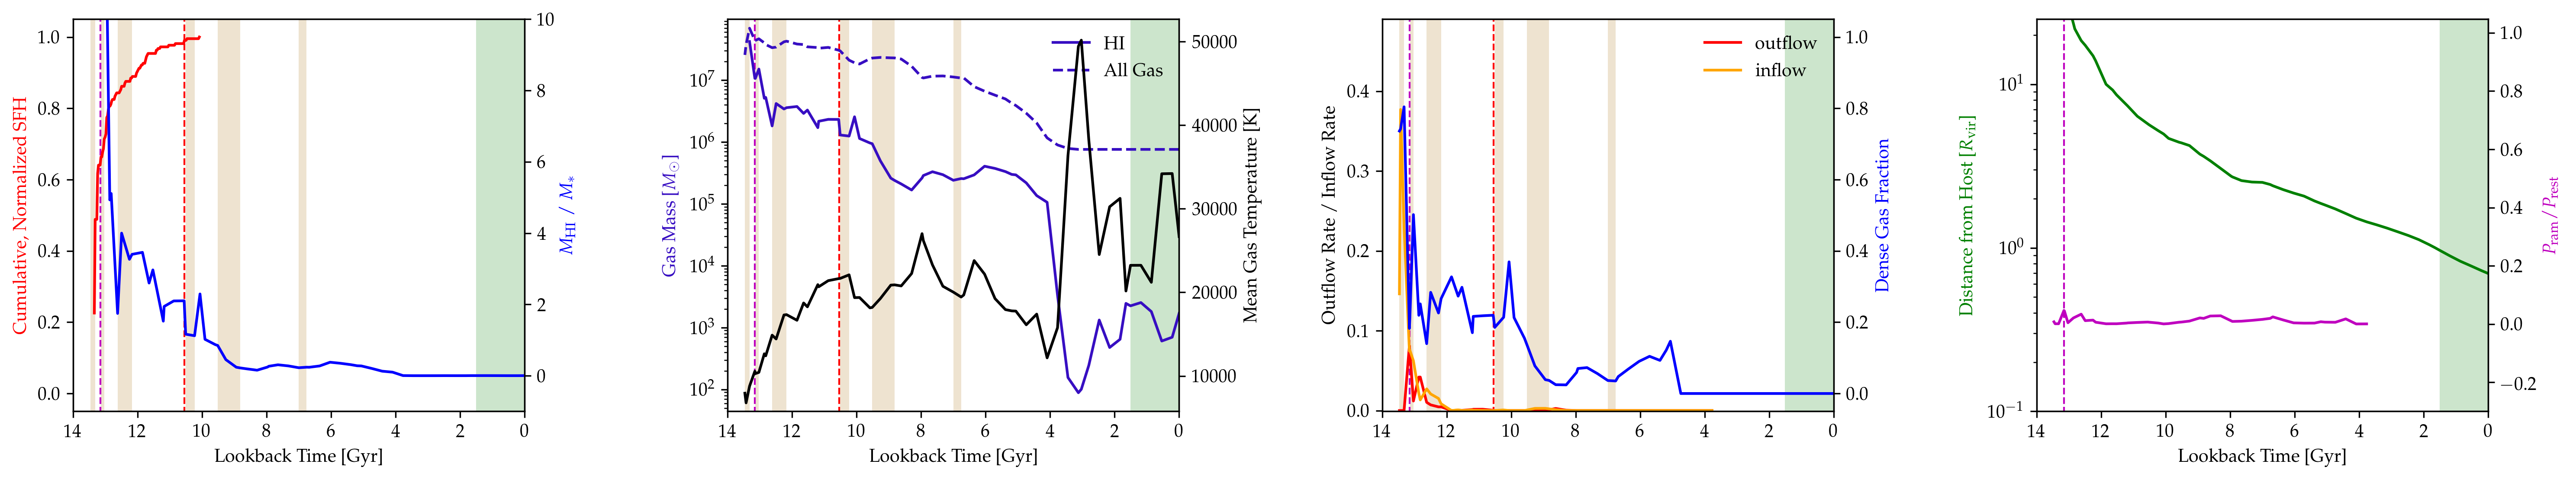

h242-71
Gathering data...


<Figure size 432x288 with 0 Axes>

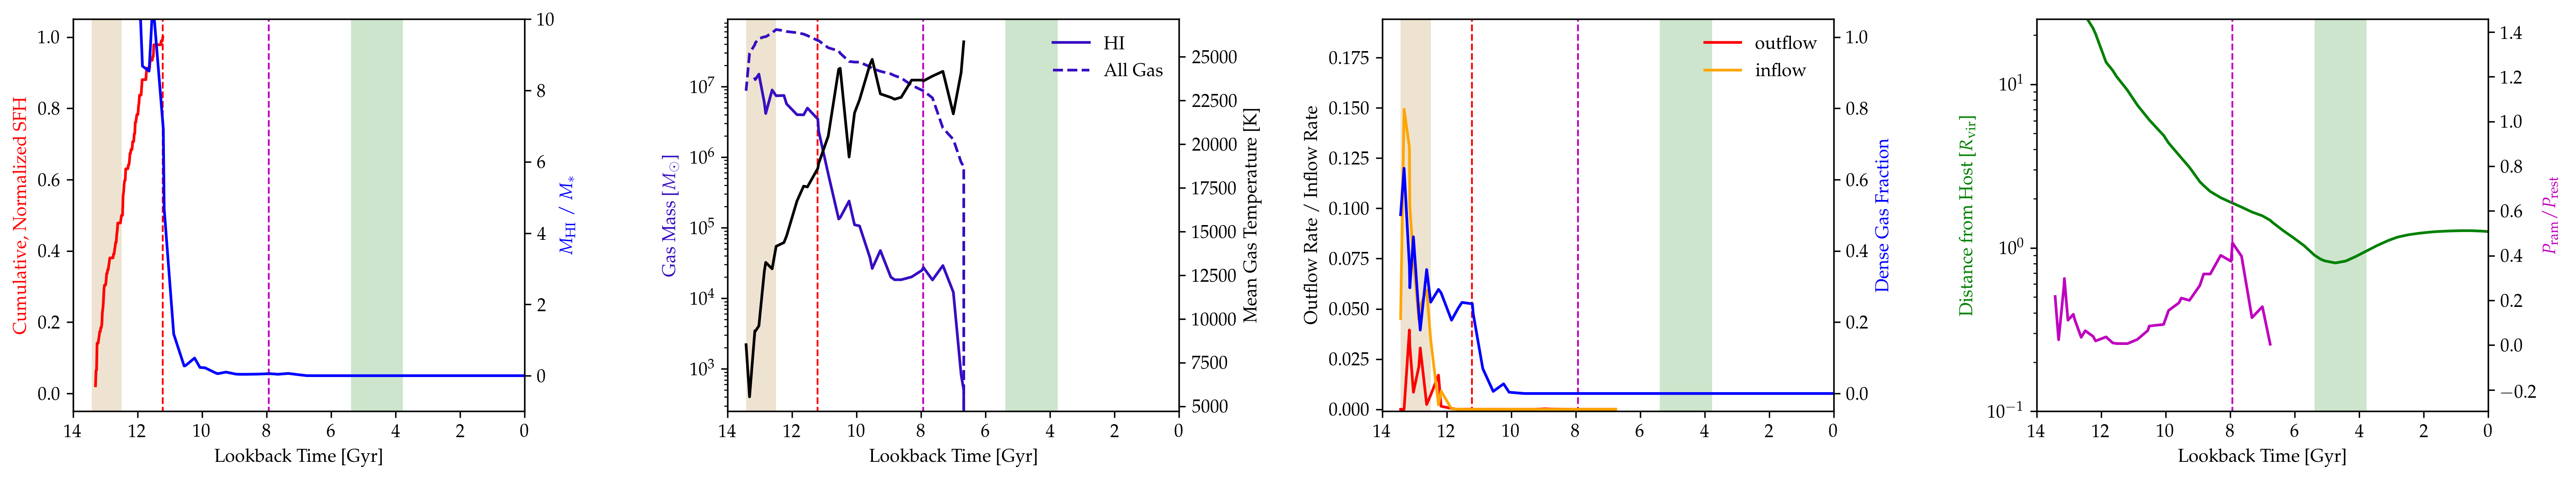

h242-78
Gathering data...


<Figure size 432x288 with 0 Axes>

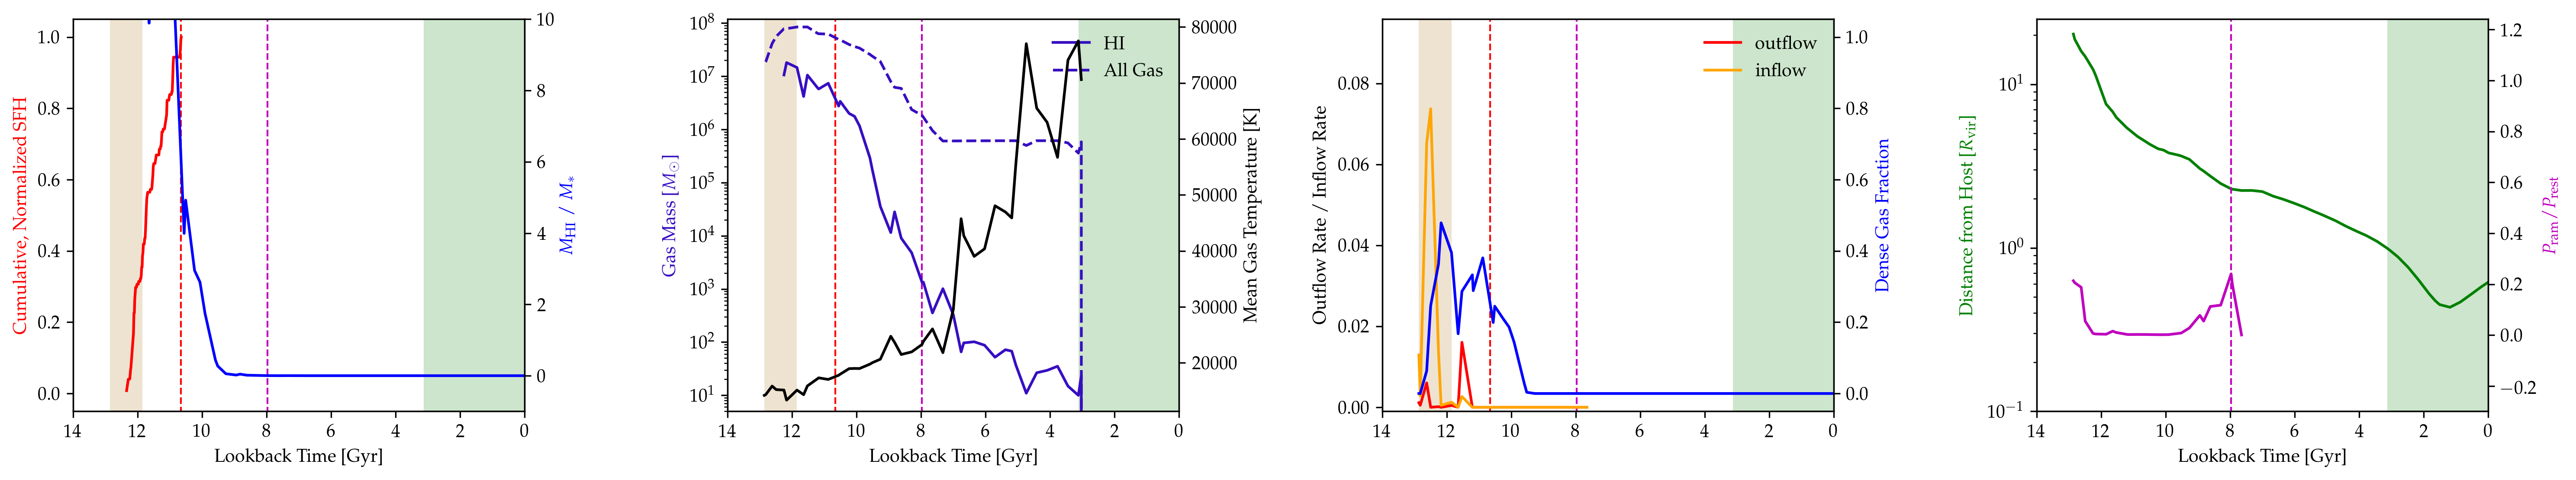

h242-86
Gathering data...


<Figure size 432x288 with 0 Axes>

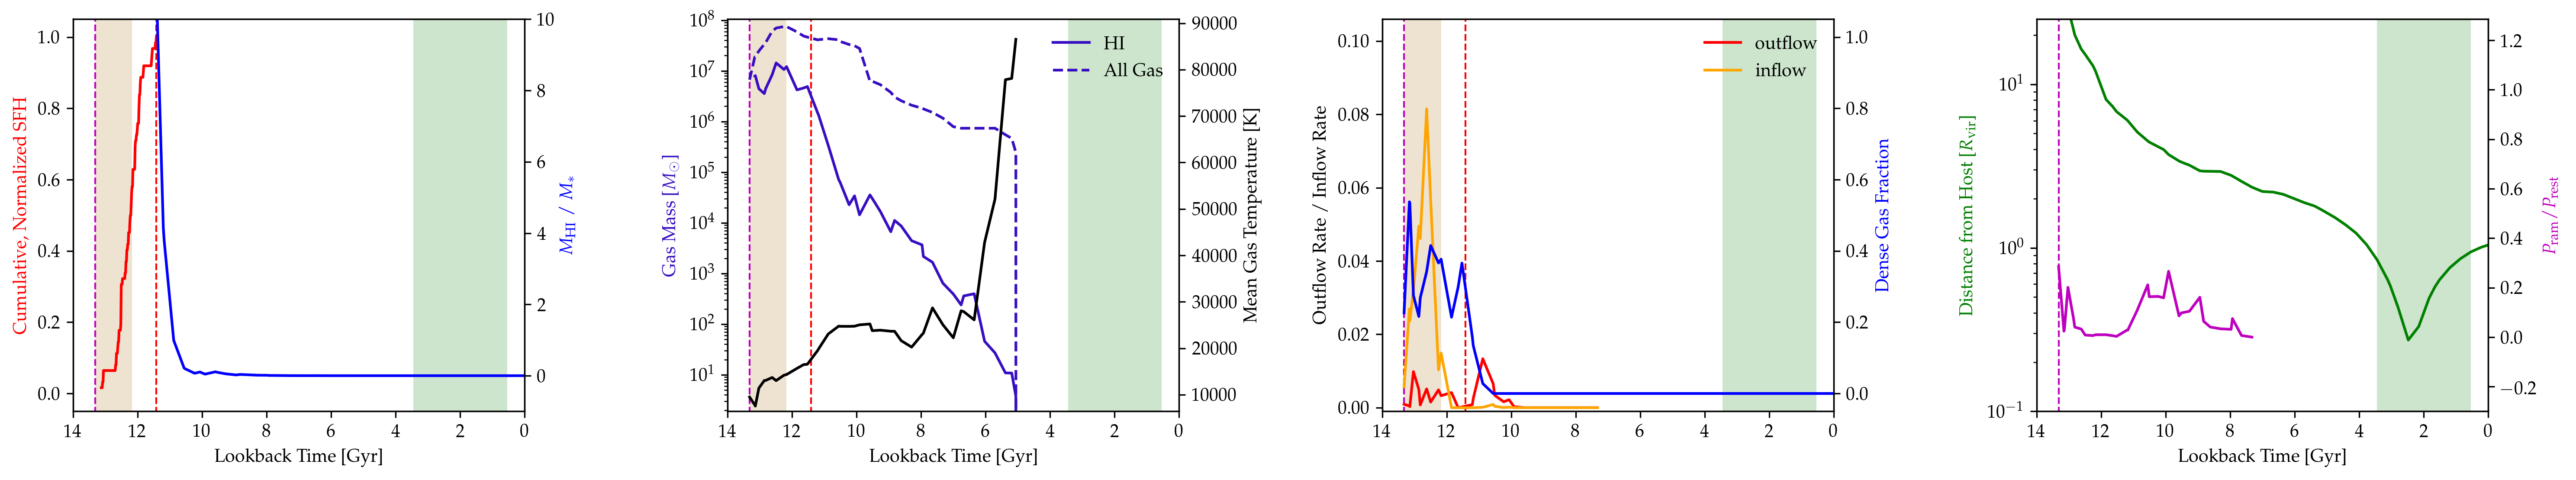

h242-223
Gathering data...


<Figure size 432x288 with 0 Axes>

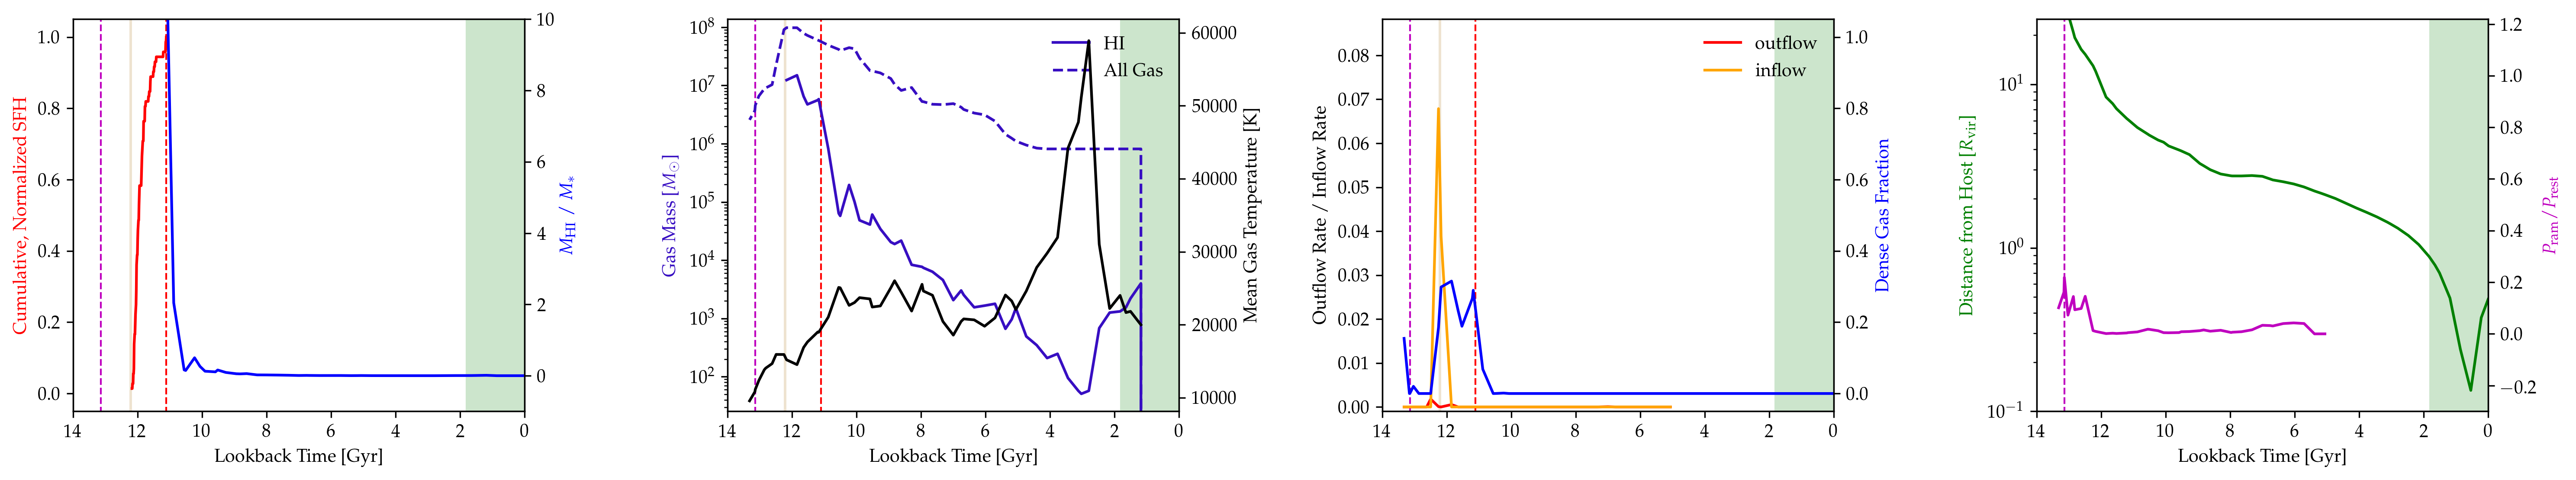

h242-480
Gathering data...


<Figure size 432x288 with 0 Axes>

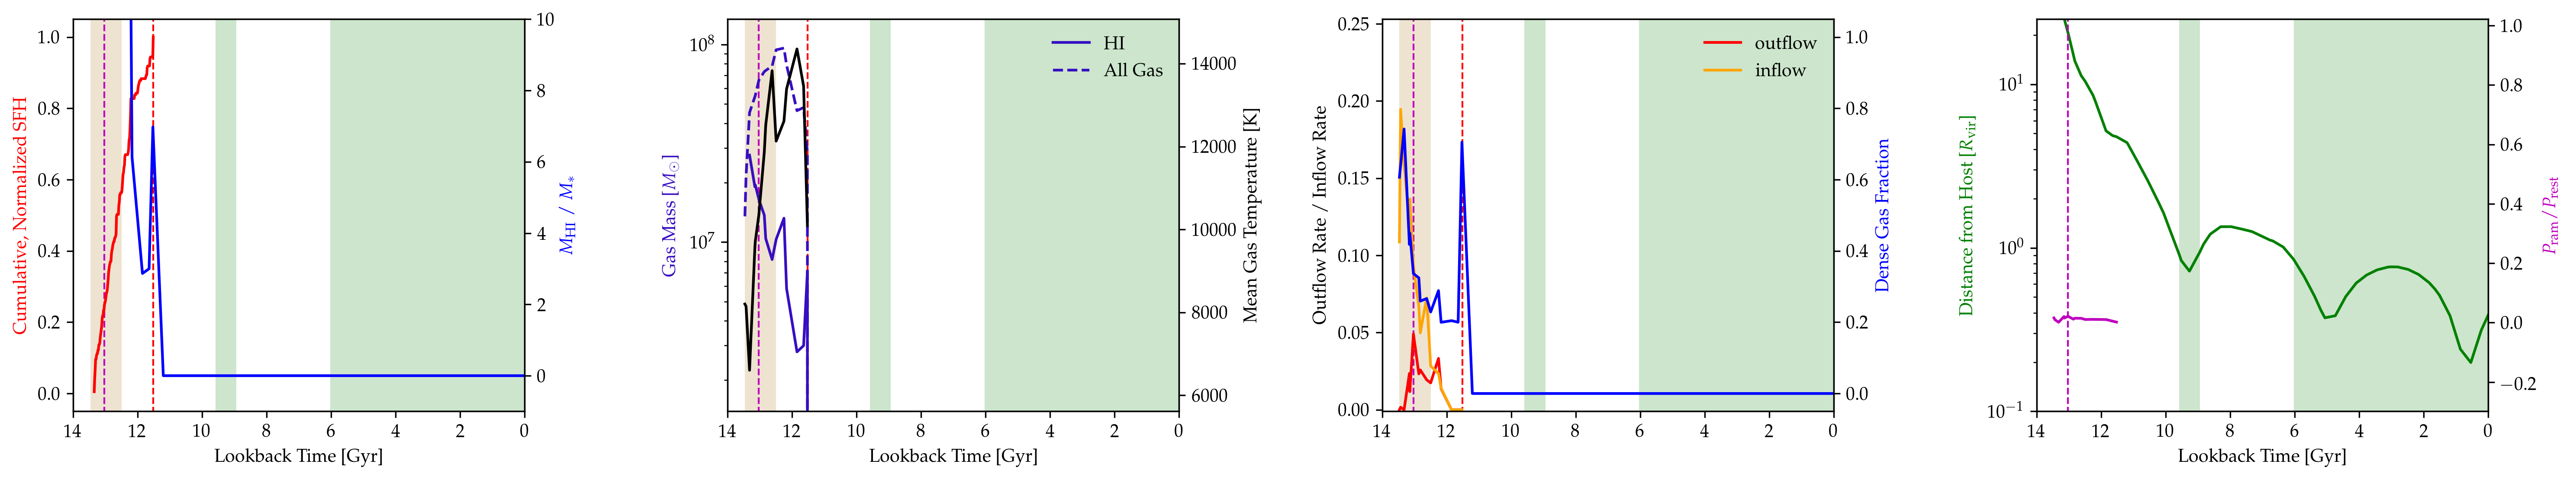

h229-53
Gathering data...


<Figure size 432x288 with 0 Axes>

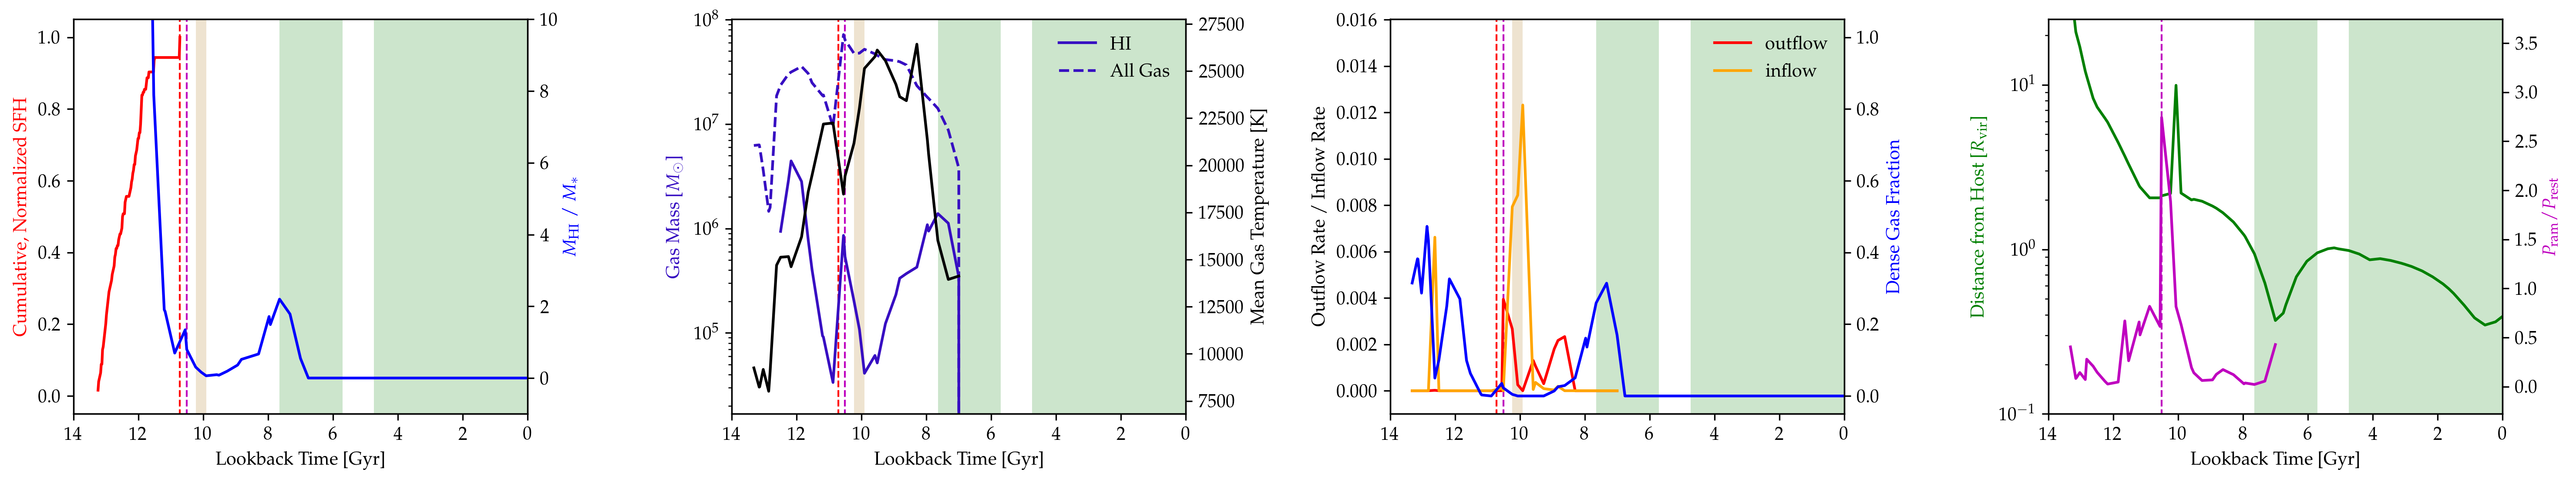

h229-113
Gathering data...


<Figure size 432x288 with 0 Axes>

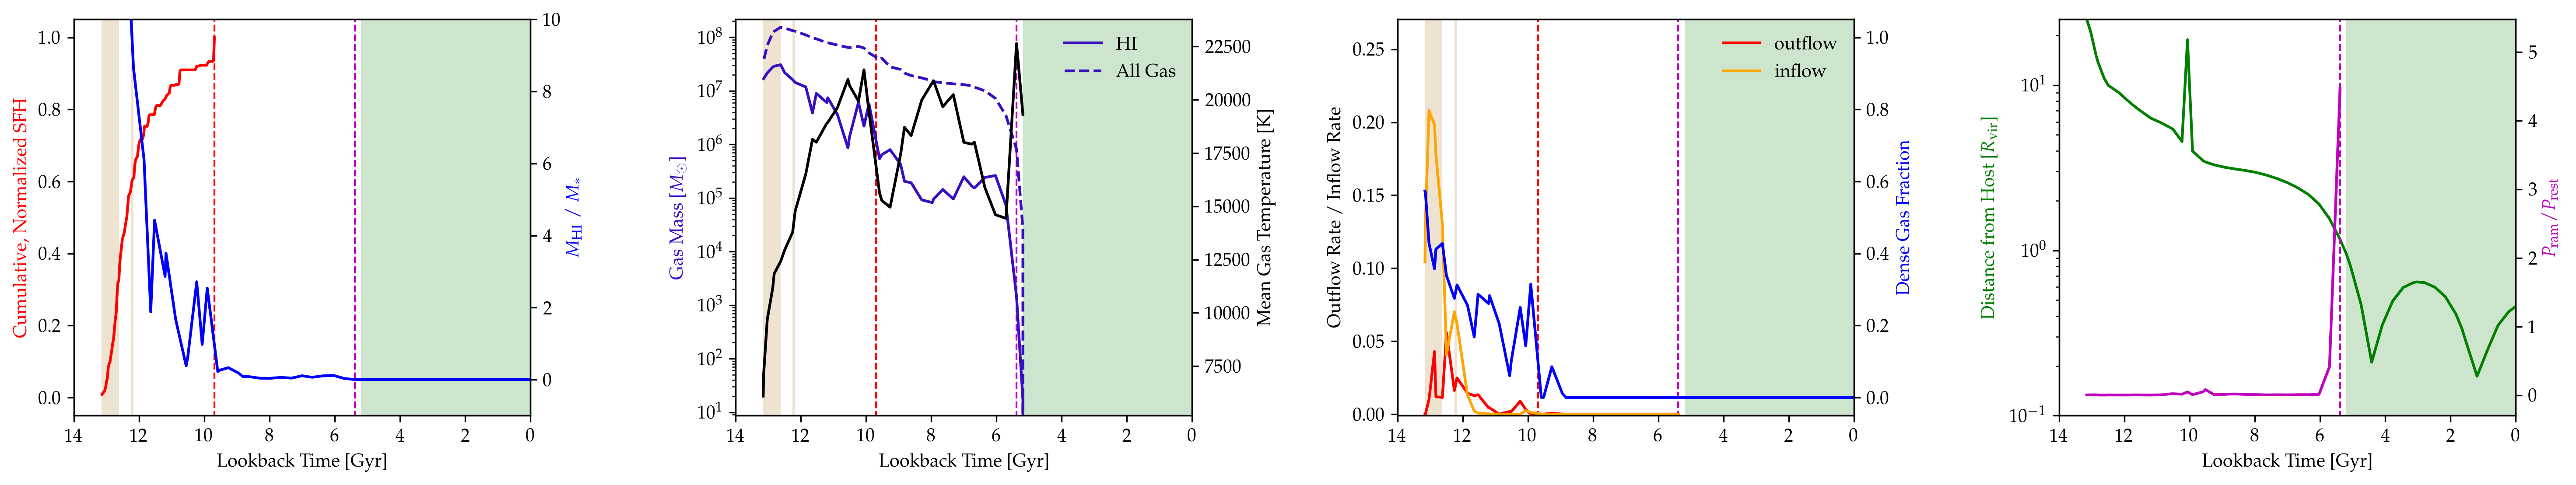

h229-212
Gathering data...


<Figure size 432x288 with 0 Axes>

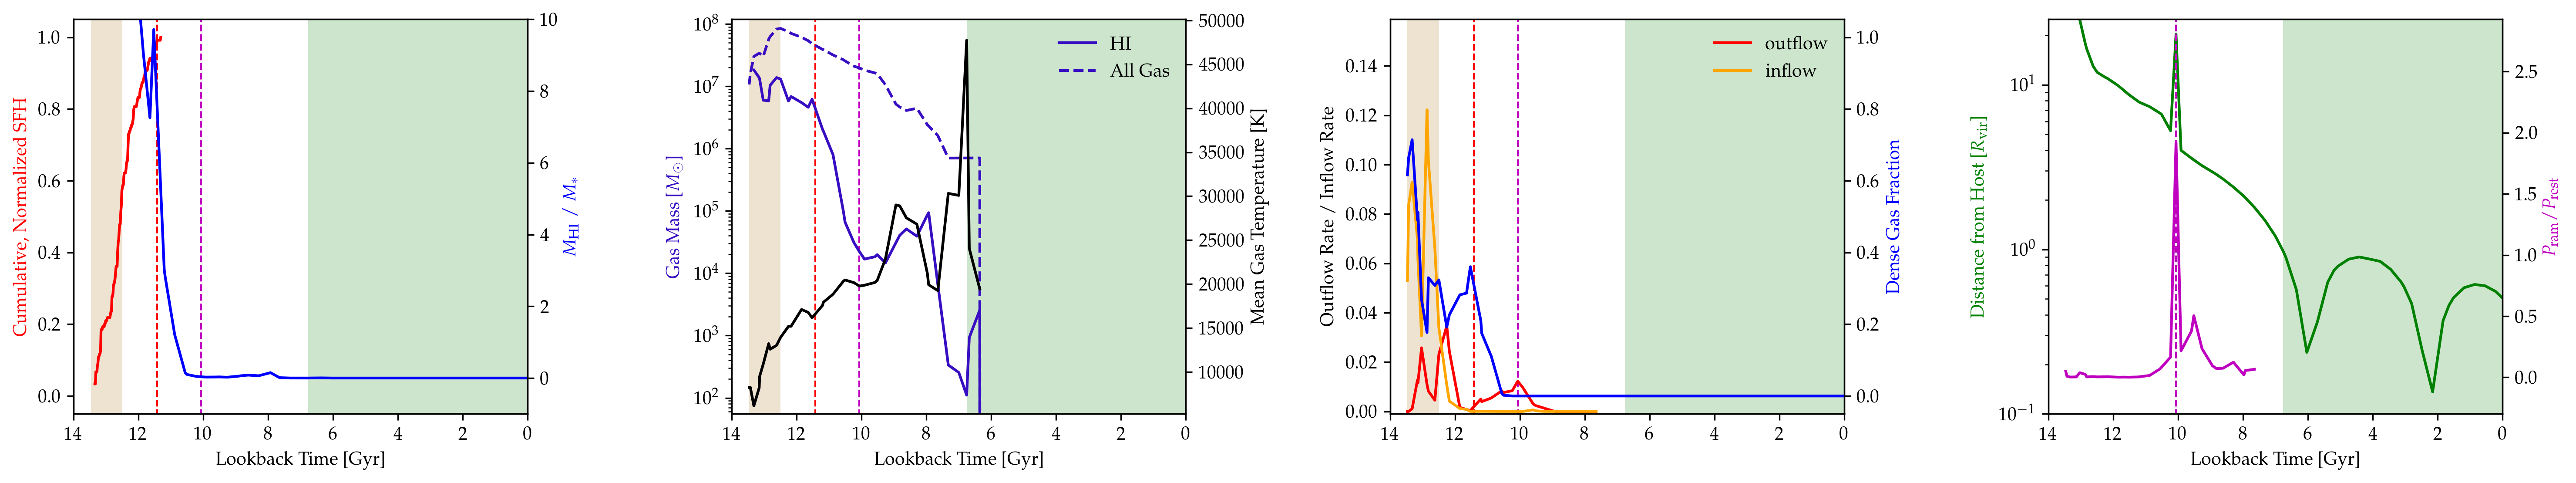

h329-40
Gathering data...


<Figure size 432x288 with 0 Axes>

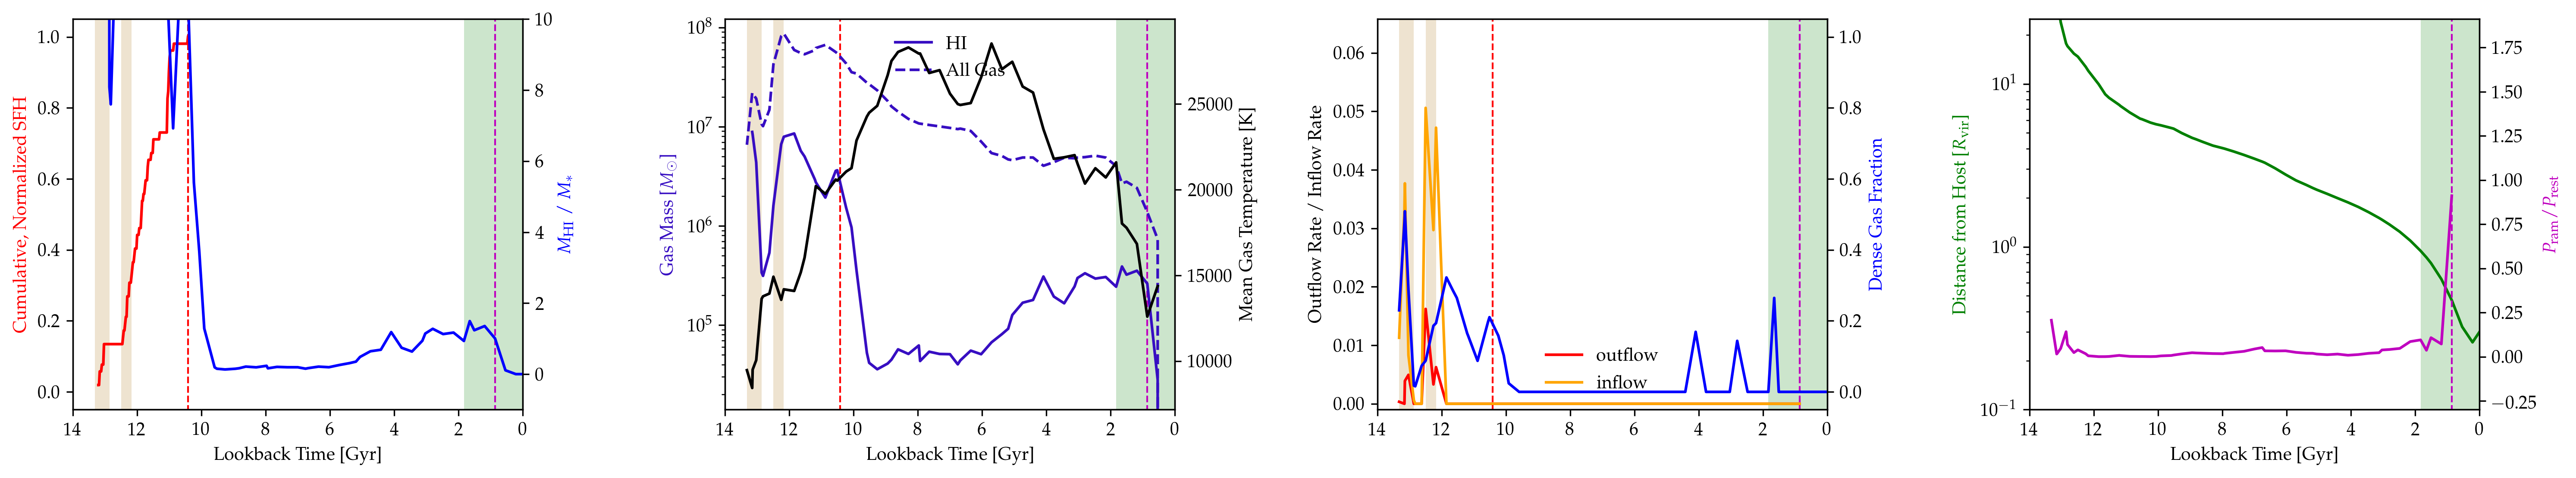

h329-133
Gathering data...


<Figure size 432x288 with 0 Axes>

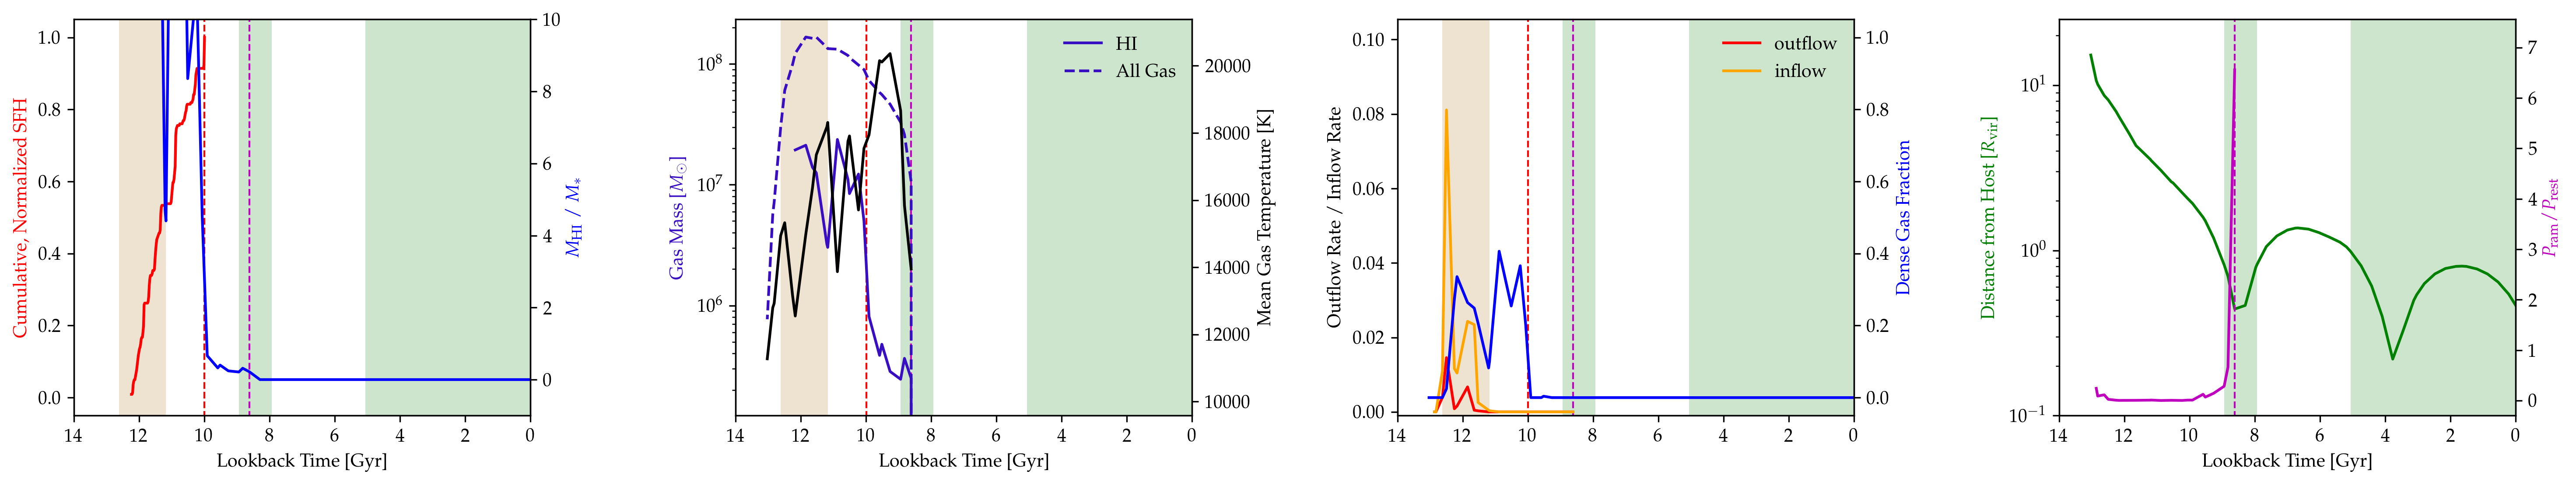

h329-137
Gathering data...


<Figure size 432x288 with 0 Axes>

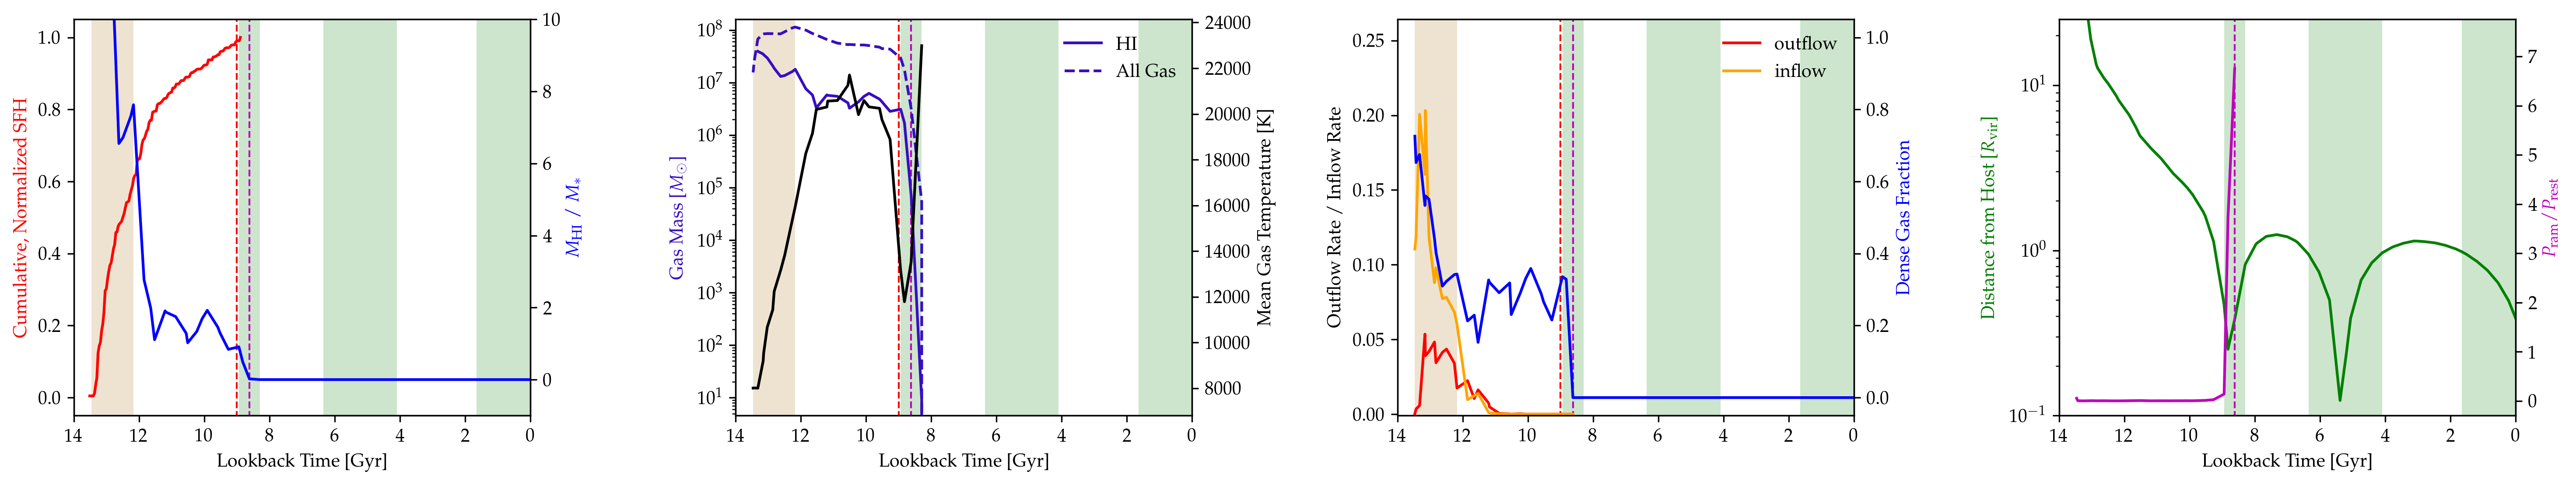

h229-33
Gathering data...


<Figure size 432x288 with 0 Axes>

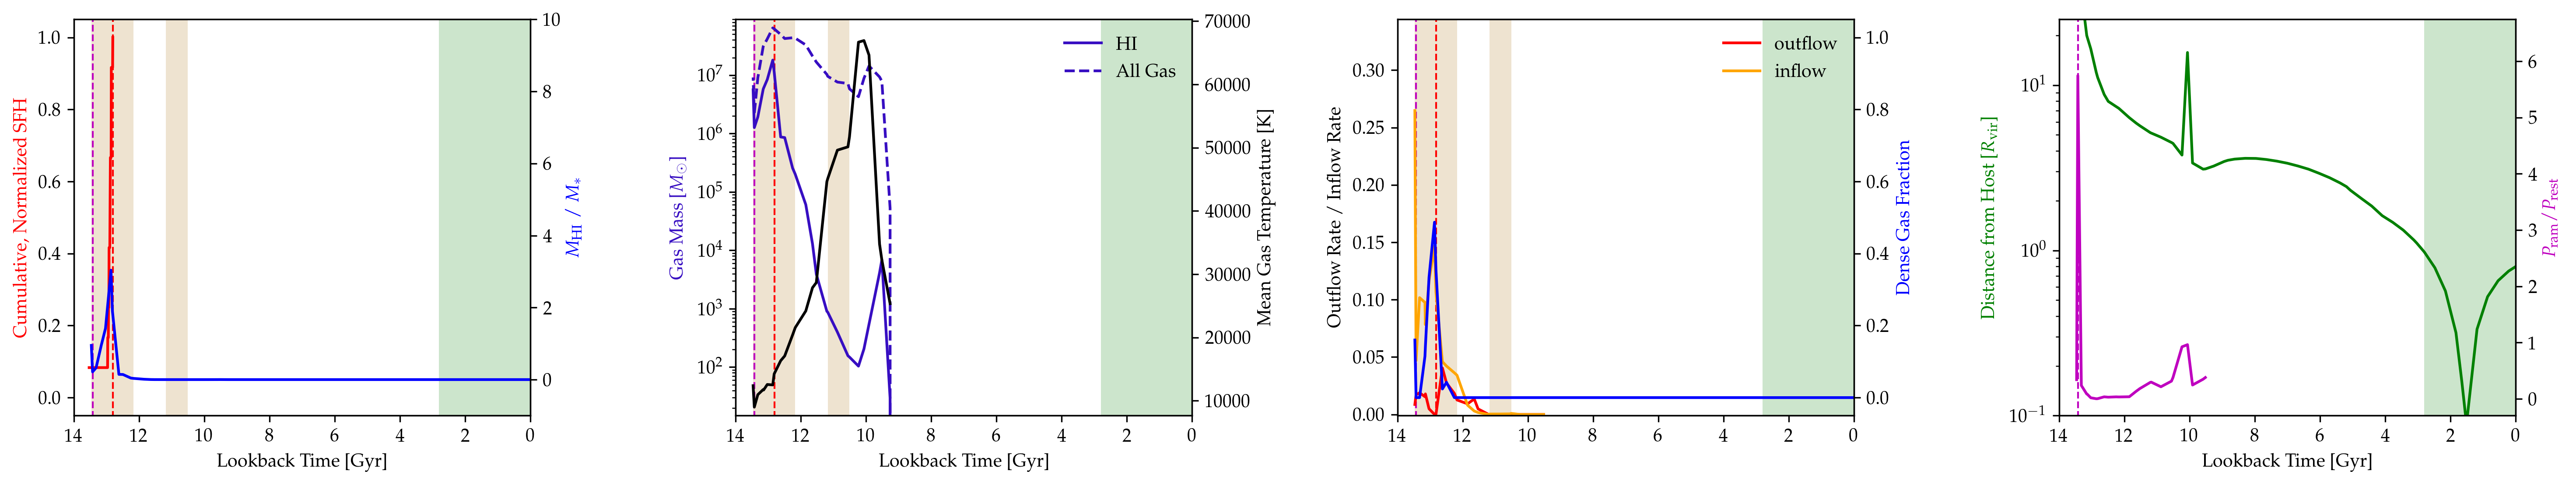

In [64]:
for sim,i in zip(sims,ids):
    print(f'{sim}-{i}')
    CaseStudyPlots(sim,i)

In [24]:
t_depls, t_until_quenchs = [],[]
for sim, i in zip(sims,ids):
    data = read_file(sim,i)
    age = 13.800797497330507
    t = age - np.array(data.time,dtype=float)
    data = data[t==np.min(t[t > 11])]
    SNHf = data.SNHfrac.tolist()[0]
    mHI = data.mHI.tolist()[0]*(1-SNHf)
    sfr = data.sfr.tolist()[0]
    Mout = data.outflow_91.tolist()[0]
    t = age - data.t.tolist()[0]
    QIdata = []
    with open('/home/akinshol/Data/Timescales/QuenchingTimescales_200b.data', 'rb') as f:
        while True:
            try:
                QIdata.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    QIdata = pd.DataFrame(QIdata)
    
    QIdata = QIdata[(QIdata.sim==sim)&(QIdata.haloid==i)]
    tquench = QIdata.tquench.tolist()[0]

    
    t_depl = mHI/(Mout+sfr)/1e9
    t_until_quench = t - tquench
    t_depls.append(t_depl)
    t_until_quenchs.append(t_until_quench)

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: divide by zero encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)


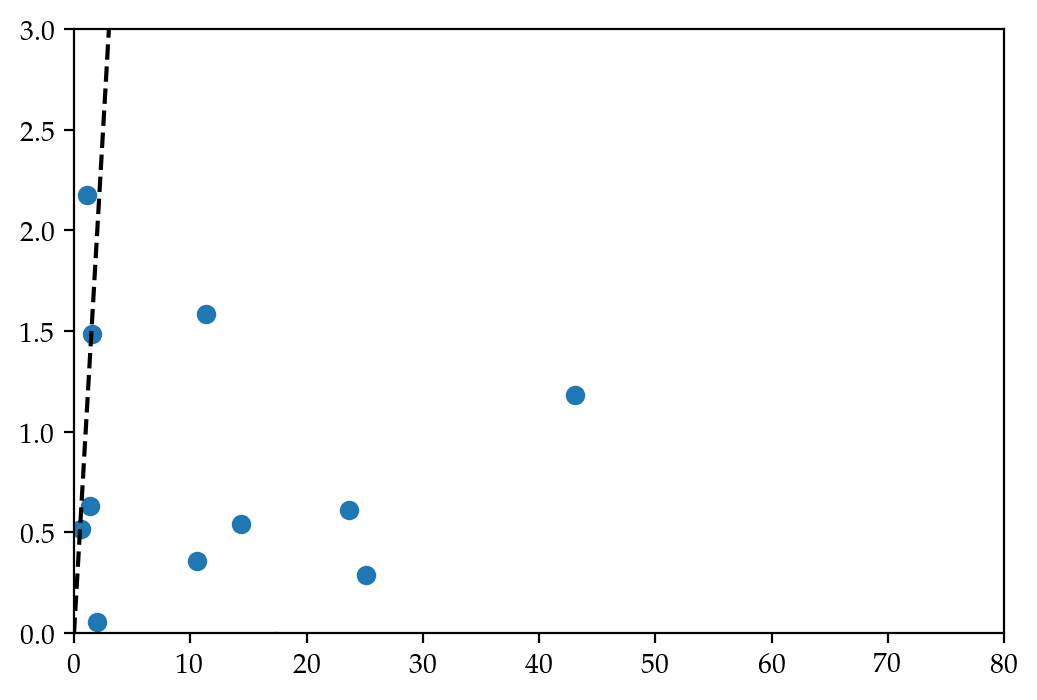

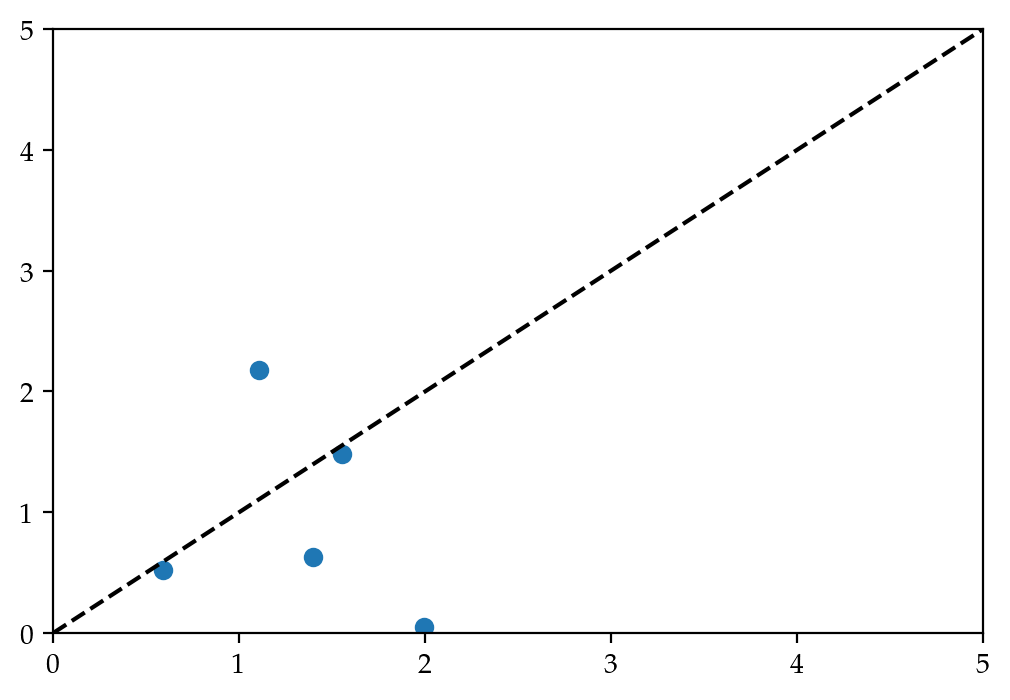

In [38]:
plt.figure(dpi=200)
plt.scatter(t_depls,t_until_quenchs)
plt.xlim(0,80)
plt.ylim(0,3)
plt.plot([0,80],[0,80],'k--')

plt.show()
plt.figure(dpi=200)
plt.scatter(t_depls,t_until_quenchs)
plt.xlim(0,5)
plt.ylim(0,5)
plt.plot([0,5],[0,5],'k--')

plt.show()

In [42]:
print(np.array(sims)[np.abs(np.array(t_depls) - np.array(t_until_quenchs)) < 1e-1])
print(np.array(ids)[np.abs(np.array(t_depls) - np.array(t_until_quenchs)) < 1e-1])

['h242' 'h229']
[ 30 113]


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [27]:
data = read_file('h329',31)
data.time

1      13.800797
12     13.585307
23     13.262072
34     12.938837
45     12.615601
56     12.292366
67     12.150951
78     11.969131
89     11.645896
100    11.322660
111    10.999425
122    10.767100
132    10.676190
142    10.352954
152    10.029719
162     9.706484
172     9.383249
182     9.060013
192     8.736778
202     8.608831
212     8.413543
222     8.090307
232     7.767072
242     7.443837
252     7.120602
262     7.039793
272     6.797366
282     6.474131
292     6.150896
302     5.868065
312     5.827660
322     5.504425
332     5.181190
342     4.975801
352     4.857955
362     4.534719
372     4.282192
382     4.211484
392     3.888249
402     3.733365
412     3.565013
422     3.288917
432     3.241778
442     2.918543
452     2.622244
462     2.595308
472     2.272072
482     2.154226
492     1.948837
502     1.625602
512     1.544793
522     1.302366
532     1.177786
542     0.979131
552     0.935360
562     0.767008
572     0.655896
581     0.642428
590     0.4774

In [32]:
tquenchs, theats = [],[]
for sim, i in zip(sims,ids):
    QIdata = []
    with open('/home/akinshol/Data/Timescales/QuenchingTimescales_200b.data', 'rb') as f:
        while True:
            try:
                QIdata.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    QIdata = pd.DataFrame(QIdata)
    QIdata = QIdata[(QIdata.sim==sim)&(QIdata.haloid==i)]
    tquench = QIdata.tquench.tolist()[0]
    
    data = read_file(sim,i)
    age = 13.800797497330507
    theat = age - np.min(data.t[data.gtemp > 1.7e4])
    
    tquenchs.append(tquench)
    theats.append(theat)

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


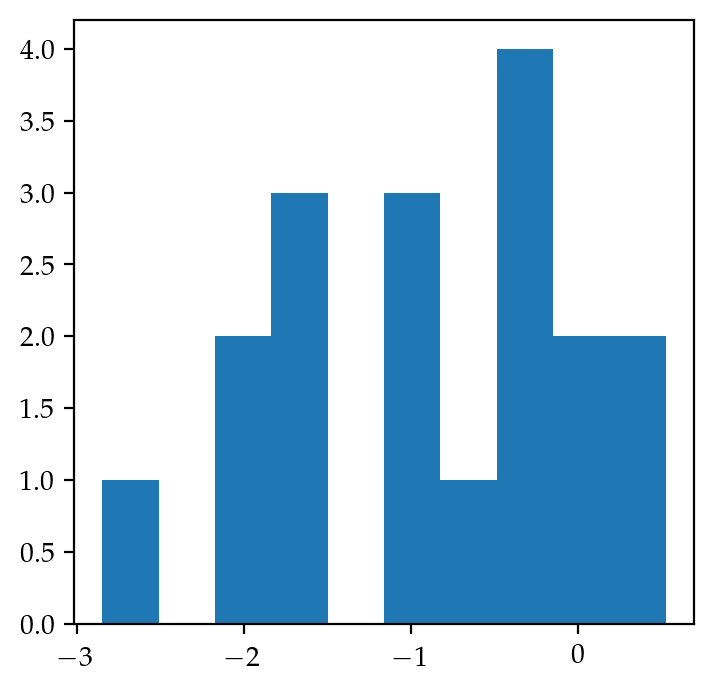

In [33]:
fig, ax = plt.subplots(1,1,figsize=(4,4),dpi=200)

ax.hist(np.array(tquenchs)-np.array(theats))
plt.show()


In [44]:
c_sfhs, bcs, = [], []
for sim, i in zip(sims,ids):
    print(f'Simulation {sim}, halo {i}')
    c_sfh, bc = cumulative_sfh(sim,i)
    c_sfhs.append(c_sfh)
    bcs.append(bc)

Simulation h148, halo 96
Simulation h148, halo 128
Simulation h148, halo 212
Simulation h148, halo 265
Simulation h148, halo 386
Simulation h148, halo 699
Simulation h242, halo 30
Simulation h242, halo 40
Simulation h242, halo 71
Simulation h242, halo 78
Simulation h242, halo 86
Simulation h242, halo 223
Simulation h242, halo 480
Simulation h229, halo 53
Simulation h229, halo 113
Simulation h229, halo 212
Simulation h329, halo 40
Simulation h329, halo 133
Simulation h329, halo 137
Simulation h229, halo 33


<Figure size 432x288 with 0 Axes>

In [45]:
sims2 = ['h148', 'h148', 'h148', 'h148', 'h148', 'h148', 'h148', 'h148', 'h148', 'h148', 'h148', 'h242', 'h229', 'h229', 'h229', 'h229', 'h229', 'h329', 'h329', 'h329']
ids2 = [41, 47, 65, 81, 119, 136, 372, 384, 442, 491, 620, 165, 52, 61, 62, 104, 290, 103, 146, 185]
for sim, i in zip(sims2,ids2):
    print(f'Simulation {sim}, halo {i}')
    c_sfh, bc = cumulative_sfh(sim,i)
    c_sfhs.append(c_sfh)
    bcs.append(bc)

In [46]:
sims3 = np.append(sims,sims2)
ids3 = np.append(ids,ids2)

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


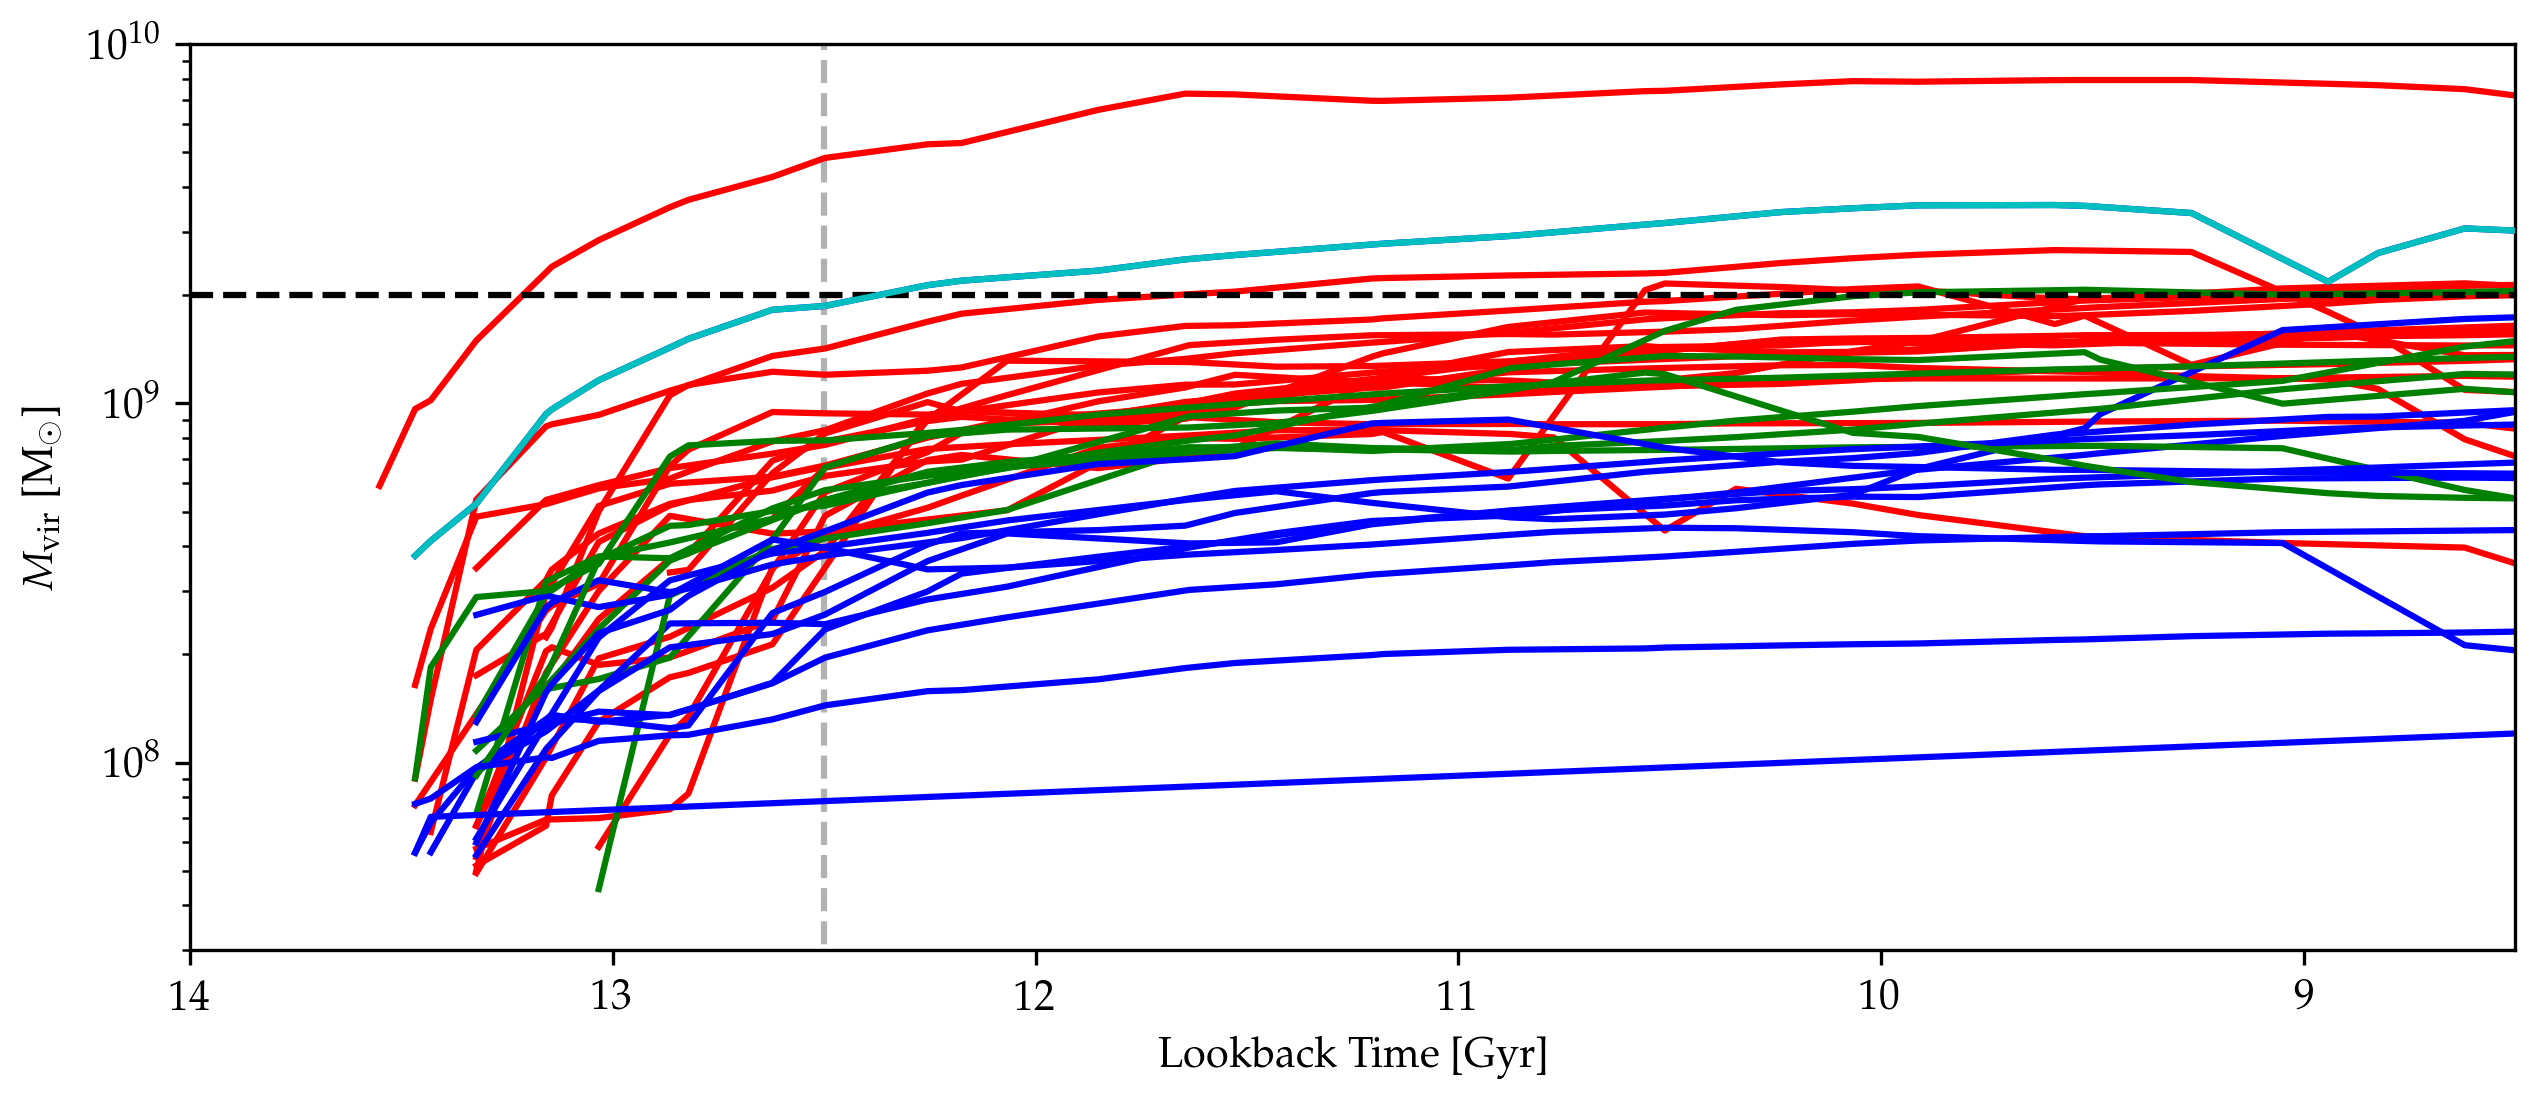

In [69]:
plt.figure(figsize=(10,4),dpi=300)
for c_sfh, bc, sim, i in zip(c_sfhs, bcs, sims3,ids3):
    data = read_file(sim,i)
    age = 13.800797497330507
    try:
        tq = np.max(bc[c_sfh > 0.99])
    except:
        continue
        
    if tq < 11.6:
        plt.plot(age - data.time, data.mass, c='r', zorder=1)
    elif tq > 12.5:
        plt.plot(age - data.time, data.mass, c='b', zorder=1)
    else:
        plt.plot(age - data.time, data.mass, c='g', zorder=1)
    
    if sim=='h229' and i==33:
        plt.plot(age - data.time, data.mass, c='c', zorder=100)
        
plt.plot([11.6,11.6],[0,0.005], 'k--', alpha=0.3, zorder=0)
plt.plot([12.5,12.5],[1,1e10], 'k--', alpha=0.3, zorder=0)
plt.plot([14,8],[2e9,2e9],'k--')

plt.xlabel('Lookback Time [Gyr]')
plt.ylabel(r'$M_{\mathrm{vir}}$ [$\mathrm{M}_{\odot}$]')

plt.semilogy()
plt.ylim(3e7,1e10)
plt.xlim(14,8.5)
plt.show()
    
    

In [74]:
mvirs, mgass, tquench, sims_m, ids_m = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
for c_sfh, bc, sim, i in zip(c_sfhs, bcs, sims3,ids3):
    data = read_file(sim,i)
    age = 13.800797497330507
    try:
        tq = np.max(bc[c_sfh > 0.99])
    except:
        continue
        
    t_reion = np.min(data.time[data.time > (age-12.5)])
    
    try:
        mvir = data.mass[data.time==t_reion].tolist()[0]
        mgas = data.mgas[data.time==t_reion].tolist()[0]
    except: 
        continue
    
    mvirs = np.append(mvirs,mvir)
    mgass = np.append(mgass,mgas)
    tquench = np.append(tquench,tq)
    sims_m = np.append(sims_m, sim)
    ids_m = np.append(ids_m, i)

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


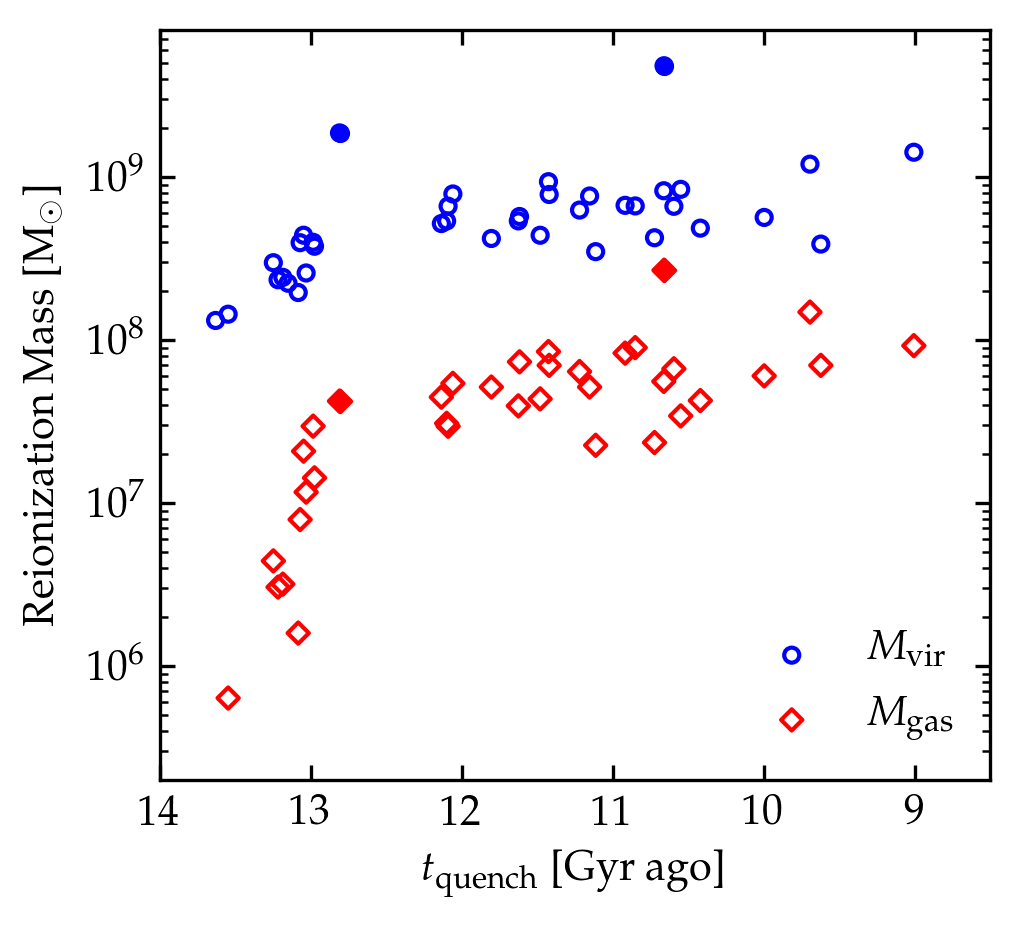

In [101]:
fig, ax = plt.subplots(1,1,figsize=(3.5,3.2),dpi=300)

ax.scatter(tquench, mvirs, label='$M_{\mathrm{vir}}$', marker='o', edgecolor='b', facecolor='none', s=13)
ax.scatter(tquench, mgass, label='$M_{\mathrm{gas}}$', marker='D', edgecolor='r', facecolor='none', s=13)


ax.scatter(tquench[((sims_m=='h229')&(ids_m==33))|((sims_m=='h242')&(ids_m==30))], 
           mvirs[((sims_m=='h229')&(ids_m==33))|((sims_m=='h242')&(ids_m==30))], 
           label=None, marker='o', color='b', s=13)
ax.scatter(tquench[((sims_m=='h229')&(ids_m==33))|((sims_m=='h242')&(ids_m==30))], 
           mgass[((sims_m=='h229')&(ids_m==33))|((sims_m=='h242')&(ids_m==30))], 
           label=None, marker='D', color='r', s=13)

ax.set_xlabel('$t_{\mathrm{quench}}$ [Gyr ago]')
ax.set_ylabel(r'Reionization Mass [$\mathrm{M}_{\odot}$]')

ax.semilogy()
ax.legend(frameon=False)
ax.set_ylim(2e5,0.8e10)
ax.set_xlim(14,8.5)

ax.tick_params(direction='in', which='both')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

plt.tight_layout()
# plt.savefig('reionization_mass.png',dpi=300)
plt.show()
    
    

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


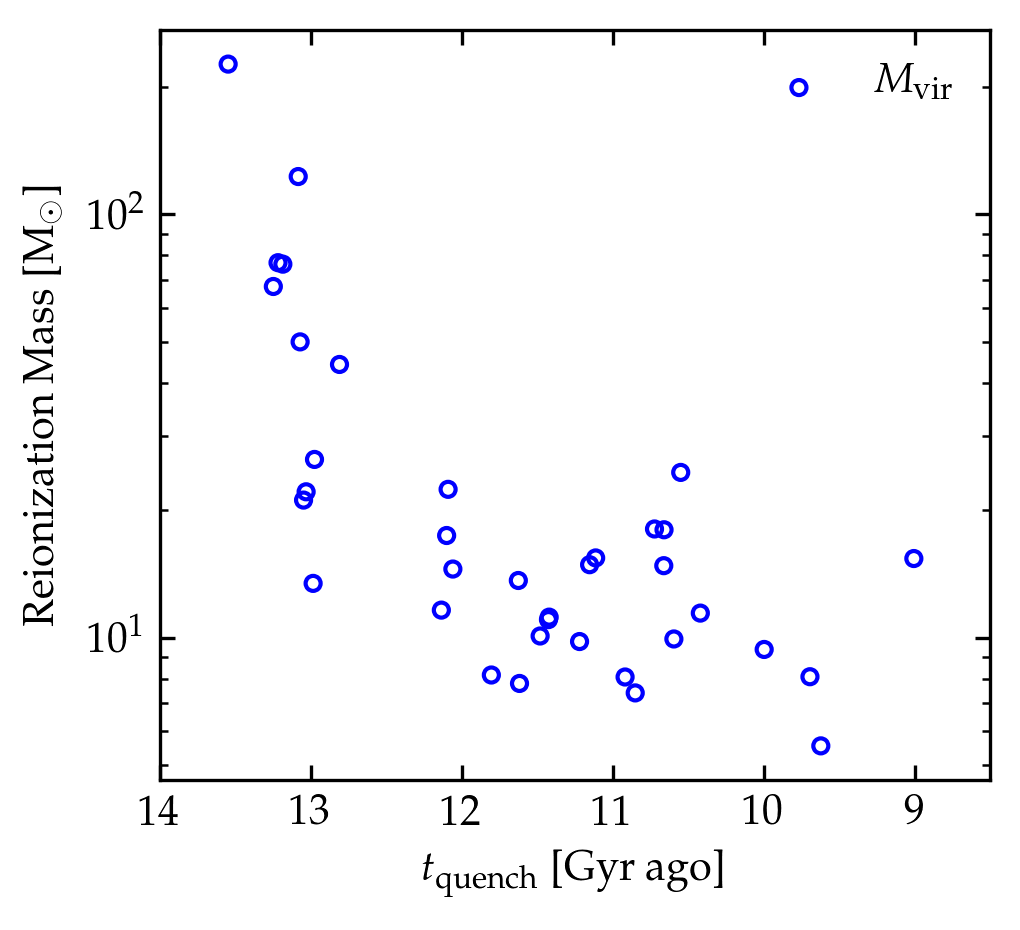

In [99]:
fig, ax = plt.subplots(1,1,figsize=(3.5,3.2),dpi=300)

ax.scatter(tquench, mvirs/mgass, label='$M_{\mathrm{vir}}$', marker='o', edgecolor='b', facecolor='none', s=13)



ax.set_xlabel('$t_{\mathrm{quench}}$ [Gyr ago]')
ax.set_ylabel(r'Reionization Mass [$\mathrm{M}_{\odot}$]')

ax.semilogy()
ax.legend(frameon=False)

ax.set_xlim(14,8.5)

ax.tick_params(direction='in', which='both')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

plt.tight_layout()
# plt.savefig('reionization_mass.png',dpi=300)
plt.show()
    
    

In [86]:
mvirs/mgass

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([ 14.86841806,   5.54866166,  10.08840968,   8.070786  ,
         7.40155537,   9.92604786,  17.98120816,  24.56566315,
         9.78837692,  14.78996307,  11.17788549,  15.42637449,
        18.05885345,   8.08307601,  11.02871044,  11.42627969,
         9.37564731,  15.37606765,  44.19868464,  22.40473323,
        13.43120335,  76.27950907,   8.15870972,  13.64470413,
        22.10777608,   7.79250446,  17.42824019,  49.97733207,
       122.86935423,  26.36299703,  14.52126784,  76.89593461,
        67.55397563,  21.13316634,          inf,  11.61381629,
       226.53954886,          inf])

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


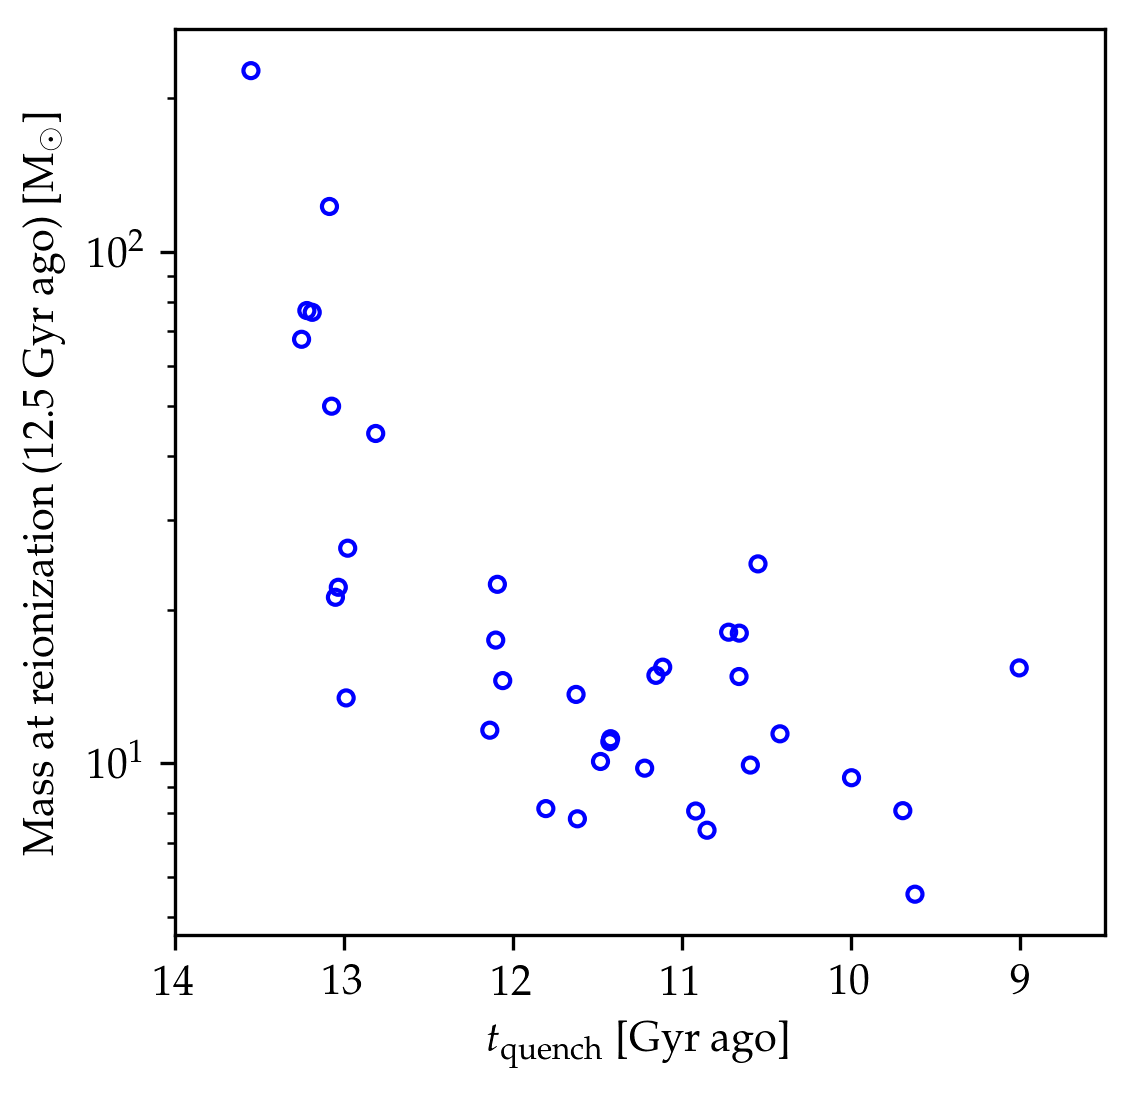

In [87]:
fig, ax = plt.subplots(1,1,figsize=(4,4),dpi=300)

ax.scatter(tquench, mvirs/mgass, label='$M_{\mathrm{vir}}$', marker='o', edgecolor='b', facecolor='none', s=13)

ax.set_xlabel('$t_{\mathrm{quench}}$ [Gyr ago]')
ax.set_ylabel(r'Mass at reionization (12.5 Gyr ago) [$\mathrm{M}_{\odot}$]')

ax.semilogy()
ax.set_xlim(14,8.5)
plt.show()
    
    

In [80]:
ids_m[np.argmax(mvirs)]

30.0

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


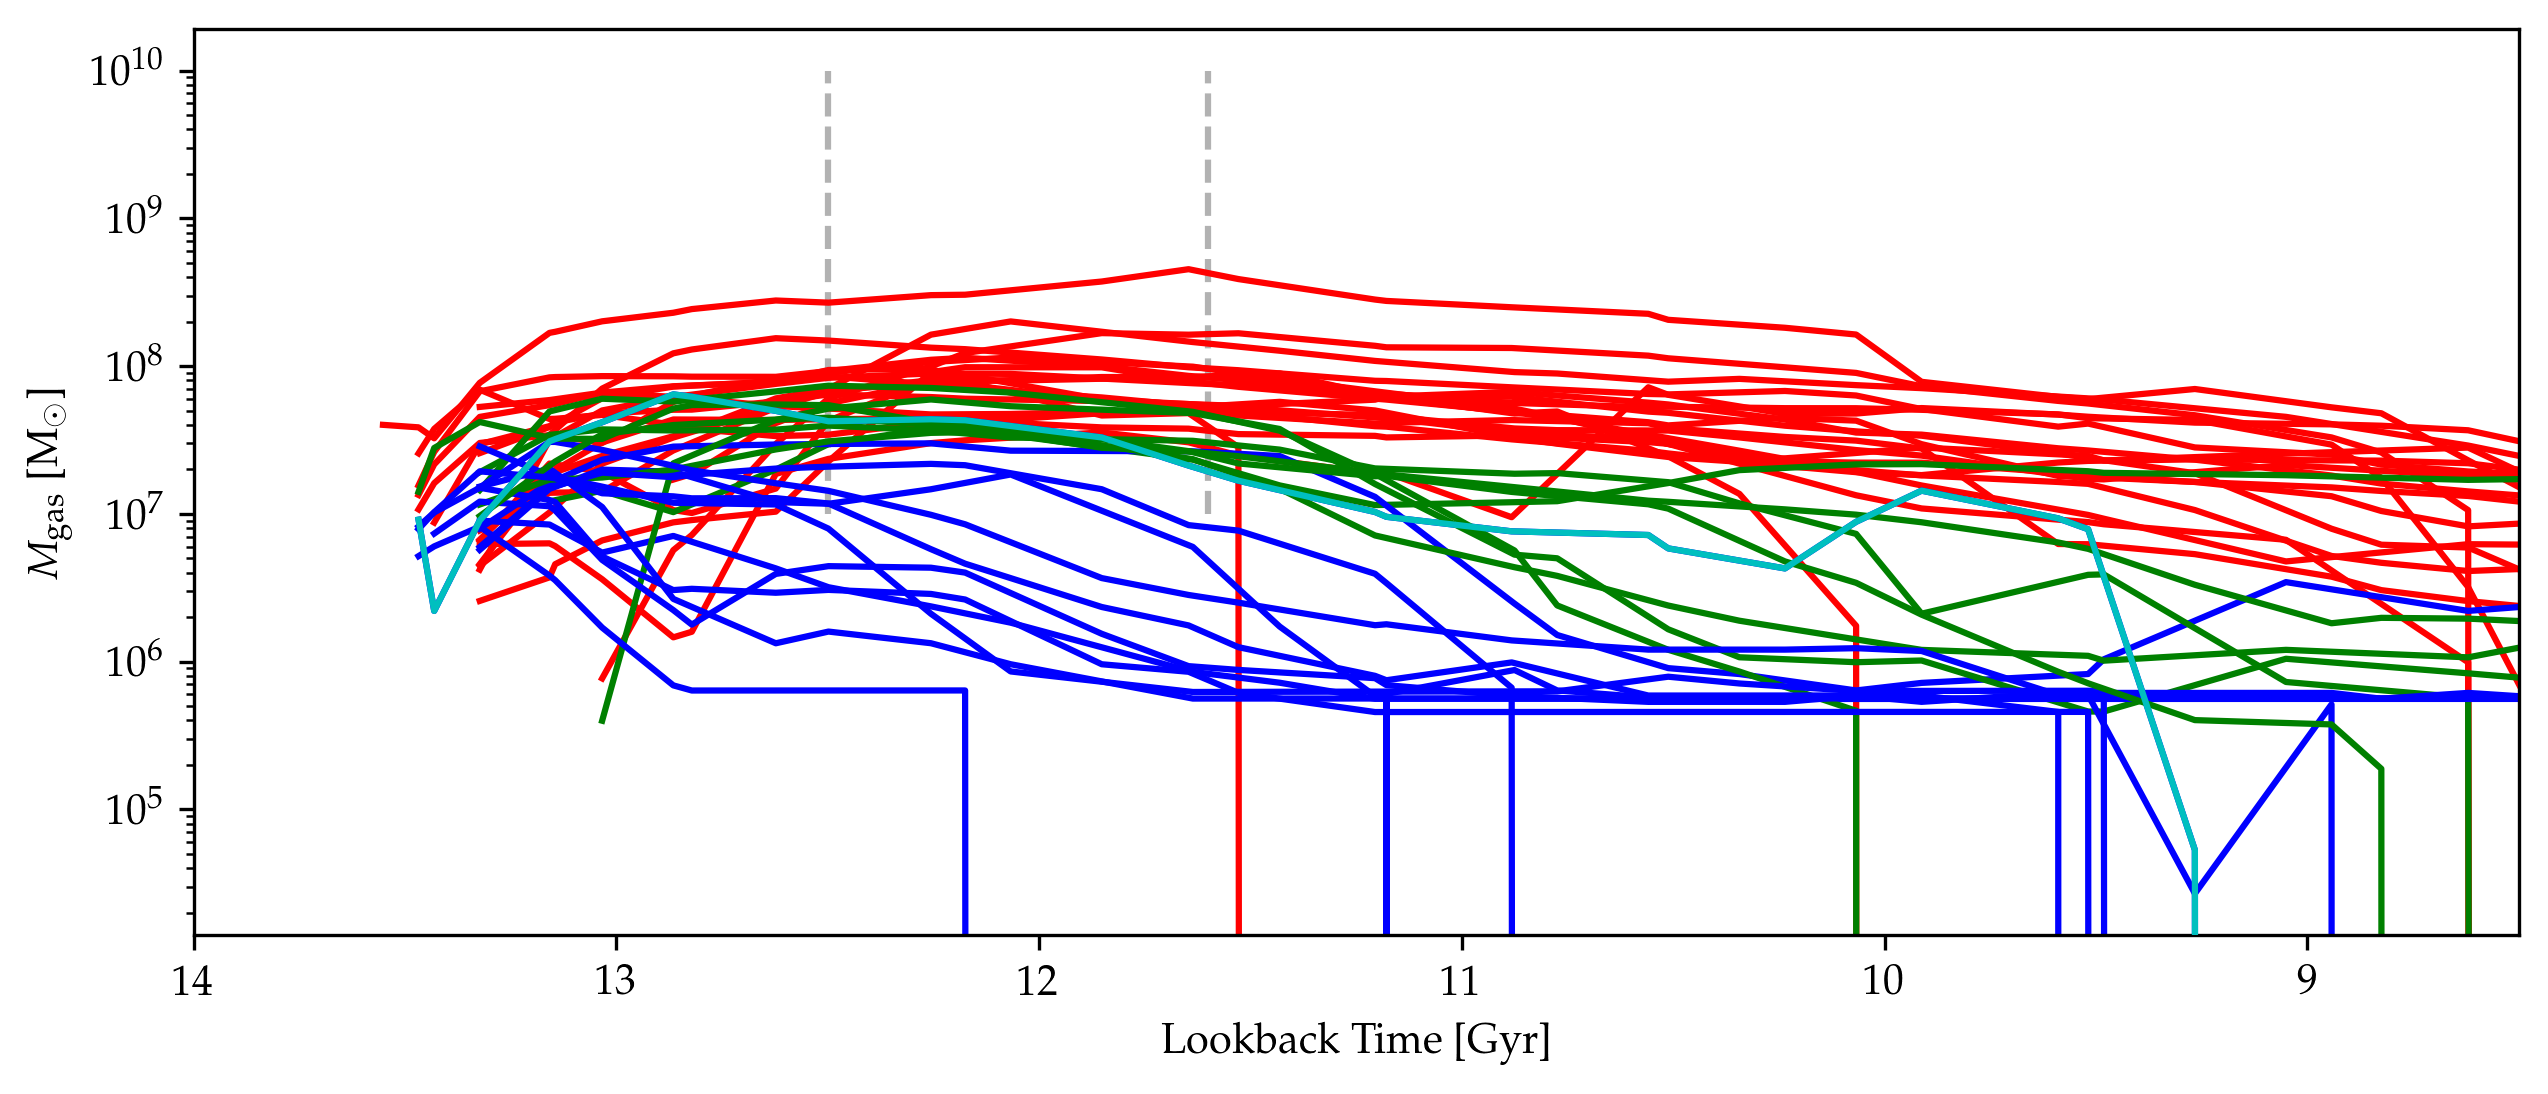

In [59]:
plt.figure(figsize=(10,4),dpi=300)
for c_sfh, bc, sim, i in zip(c_sfhs, bcs, sims3,ids3):
    data = read_file(sim,i)
    age = 13.800797497330507
    try:
        tq = np.max(bc[c_sfh > 0.99])
    except:
        continue
        
    if tq < 11.6:
        plt.plot(age - data.time, data.mgas, c='r', zorder=1)
    elif tq > 12.5:
        plt.plot(age - data.time, data.mgas, c='b', zorder=1)
    else:
        plt.plot(age - data.time, data.mgas, c='g', zorder=1)
    
    if sim=='h229' and i==33:
        plt.plot(age - data.time, data.mgas, c='c', zorder=100)
        
plt.plot([11.6,11.6],[1e7,1e10], 'k--', alpha=0.3, zorder=0)
plt.plot([12.5,12.5],[1e7,1e10], 'k--', alpha=0.3, zorder=0)

plt.xlabel('Lookback Time [Gyr]')
plt.ylabel(r'$M_{\mathrm{gas}}$ [$\mathrm{M}_{\odot}$]')

plt.semilogy()
plt.xlim(14,8.5)
plt.show()
    
    

In [104]:
data = read_file('h242',41)
print(f'Stellar mass {data.mstar[data.time > 13.6].tolist()[0]:.2e}')
data = read_file('h229',55)
print(f'Stellar mass {data.mstar[data.time > 13.6].tolist()[0]:.2e}')

Stellar mass 1.83e+06
Stellar mass 6.79e+06


Stellar mass 6.79e+06
